<a href="https://colab.research.google.com/github/NelsonPixels/TensorFlow-CheatSheet/blob/main/Malaria_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow_probability as tfp
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import albumentations as A
import cv2
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete238B8O/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [97]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path=PosixGPath('/tmp/tmpitcfpw6ctfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},

In [98]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))


  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))


  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [99]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

#dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(train_dataset, val_dataset, test_dataset)
print(list(train_dataset.take(1).as_numpy_iterator()),list(val_dataset.take(1).as_numpy_iterator()),list(test_dataset.take(1).as_numpy_iterator()))



<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))> <_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))> <_SkipDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0,

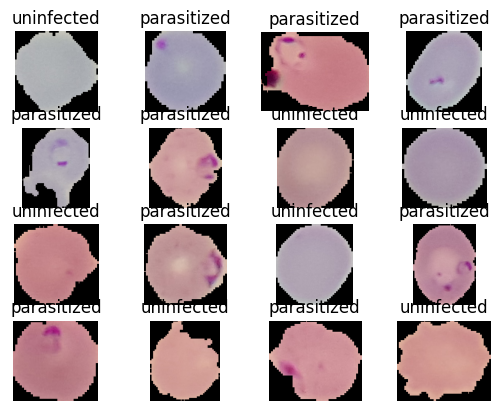

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

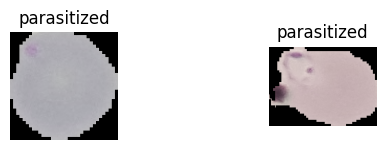

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(2)):
  plt.subplot(1,4, 2*i + 1)
  plt.imshow(image)

  plt.subplot(1,4, 2*i + 1)
  plt.imshow(tf.image.adjust_saturation(image, 0.3))

  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
dataset_info.features['label'].int2str(1)

'uninfected'

Data Preprocessing

Data Augmentation

In [ ]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [ ]:
original_image, label = next(iter(train_dataset))

In [ ]:
augmented_image = tf.image.flip_left_right(original_image) # flip an image from left to right. permits us to augment our dataset x2

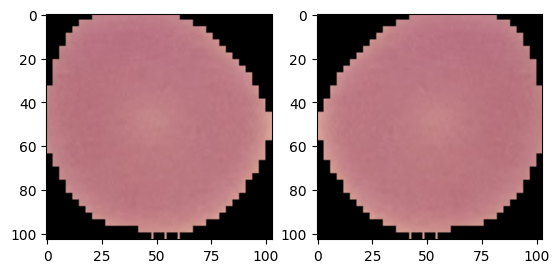

In [ ]:
visualize(original_image, augmented_image)

In [100]:
IM_SIZE = 224
original_image, label = next(iter(train_dataset))

@tf.function
def resize_rescale(image, label):
  print('Hello!!')
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

_, _=resize_rescale(original_image, label)

Hello!!


In [101]:
# tf.image augment
@tf.function
def augment(image, label):

  image, label = resize_rescale(image, label)
  image = tf.image.rot90(image)
  #image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
  #image = tf.image.stateless_random_saturation(image, 0.3, 0.5)
  image = tf.image.stateless_random_flip_left_right(image)

  return image, label

In [102]:
class RotNinety(Layer):
  def __init__(self):
    super().__init__()

  @tf.function
  def call(self, image):
    return tf.image.rot90(image)

In [103]:
# tf.keras.layer resizing and rescaling
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0/255),
])

In [104]:
# tf.keras.layer augment
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(0.25, 0.2501),),
    RandomFlip(mode='horizontal',),
    ]
)

@tf.function
def augment_layer(image, label):
  return augment_layers(resize_rescale_layers(image), training=True), label

Mixup Data augmentation

In [105]:
train_dataset_1 = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resize_rescale)
train_dataset_2 = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resize_rescale)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

Hello!!


In [ ]:
def mixup(train_dataset_1, train_dataset_2):

  (image_1,label_1),(image_2,label_2) = train_dataset_1, train_dataset_2

  #image_1 = cv2.imread('cat.jpg'), (IM_SIZE, IM_SIZE)
  #image_2 = cv2.imread('dog.jpg'), (IM_SIZE, IM_SIZE)

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  image = lamda*image_1 + (1-lamda)*image_2
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)
  return image, label

#print(image.shape, label)
#plt.imshow(image/255)


In [ ]:
def box(lamda):
  IM_SIZE = 224

  r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype= tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype= tf.int32)

  r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
  r_y = tf.clip_by_value(r_y - r_w//2, 0, IM_SIZE)

  x_b_r = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
  y_b_r = tf.clip_by_value(r_y - r_w//2, 0, IM_SIZE)

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return print(r_y, r_x, r_h, r_w)



Cutmix Data Augmentation

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1),(image_2,label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, 20, 15, IM_SIZE, IM_SIZE)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, 20, 15, IM_SIZE, IM_SIZE)

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1 - (r_w*r_h)/(IM_SIZE*IM_SIZE), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

Albumentation

In [ ]:
transforms = A.Compose([
    A.Resize(IM_SIZE, IM_SIZE),
    A.OneOf([A.HorizontalFlip(), A.VerticalFlip(),], p=0.3),
    A.RandomRotate90(),
    #A.RandomGridShuffle(),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=0.5),
    #A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
    #A.Sharpen(alpha=(0.2,0.5), lightness=(0.5,1.0), always_apply=False, p=0.5)
])

In [ ]:
def aug_albument(image):
  data  = {"image":image}
  image = transforms(**data)
  image = image["image"]
  image = tf.cast(image/255., tf.float32)

  return image

In [ ]:
def process_data(image, label):
  aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
  return aug_img, label

In [ ]:
BATCH_SIZE = 32
train_dataset = (
    mixed_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration=True)
    #.map(cutmix)
    .map(mixup)
    #.map(process_data)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
)
train_dataset

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
im, =next(iter(train_dataset))
plt.imshow(im[0])

In [ ]:
plt.figure(figsize=(110,10))

for i in range(1,32):
  plt.subplot(8,4,i)
  plt.imshow(im[i])

In [ ]:
#test_dataset = test_dataset.map(resize_rescale_layers)

In [ ]:
for image. label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(133, 154, 3), dtype=uint8) tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
BATCH_SIZE = 32
train_dataset = (
    mixed_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration=True)
    .map(mixup)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
BATCH_SIZE = 32
val_dataset = (
    val_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration=True)
    #.map(cutmix)
    #.map(mixup)
    .map(resize_rescale)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
)
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Sequential API

In [ ]:
IM_SIZE = 224
dropout_rate = 0.3
regularization_rate = 0.01
model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3)),
    resize_rescale_layers,
    augment_layers,

    Conv2D(filters = 6, kernel_size=3, strides=1, padding='valid', activation = 'relu', kernel_regularizer = L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
    Dropout(rate = dropout_rate),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu', kernel_regularizer = L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation = "relu", kernel_regularizer = L2(regularization_rate)),
    BatchNormalization(),
    Dropout(rate = dropout_rate),

    Dense(10, activation = "relu", kernel_regularizer = L2(regularization_rate)),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)      

Functional API

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size=3, strides=1, padding='valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)


feature_extractor_model = Model(func_input, output, name = "Feature_extractor")
feature_extractor_model.summary()

Model: "Feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)

In [ ]:
IM_SIZE = 224
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size=3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

])

feature_extractor_seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_6 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_7 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor_seq_model(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_8 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                       

In [ ]:
y_true = [0,1,0,0]
y_pred = [0.6,0.51,0.94,1]
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9340706>

Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor,self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation )
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D (pool_size = pool_size, strides=2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D (pool_size = pool_size, strides=2*strides)

  def call(self, x, training):
    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)
    return x
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_12 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                

In [ ]:
class LenetModel(Model):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(LenetModel,self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)
    return x

lenet_sub_classed = LenetModel(8, 3, 1, "valid", "relu", 2)
lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_16 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_17 (Ba  multiple                  

In [ ]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self,input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1],self.output_units), initializer = "random_normal", trainable = True)
    self.b = self.add_weight(shape = (self.output_units,), initializer = "random_normal", trainable = True)

  def call(self, input_features):
    pre_output = tf.matmul(input_features, self.w) + self.b

    if(self.activation == "relu"):
      return tf.nn.relu(pre_output)

    elif(self.activation == "sigmoid"):
      return tf.math.sigmoid(pre_output)

    else:
      return pre_output


In [ ]:
IM_SIZE = 224
lenet_custom_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size=3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),


    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    NeuralearnDense(100, activation = "relu"),
    BatchNormalization(),

    NeuralearnDense(10, activation = "relu"),
    BatchNormalization(),

    NeuralearnDense(1, activation = "sigmoid"),
])

lenet_custom_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_18 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_19 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

Callbacks

In [ ]:
class LossCallBack(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {}, the method has a loss of {}".format(epoch+1,logs["loss"]))

  def on_batch_end(self, batch, logs):
    print("\n For Batch number {} the model has a loss of {}".format(batch+1,logs))

CSVLogger

In [ ]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=False
)

EarlyStopping

In [ ]:
es_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)


LearningRateScheduler

In [ ]:
def scheduler(epoch, lr):
  if epoch <= 1:
    learning_rate = lr
  else:
    learning_rate = lr * tf.math.exp(-0.1)
    learning_rate = learning_rate.numpy()
  with train_writer.as_default():
    tf.summary.scalar('Learning Rate', data = learning_rate, step = epoch)
  return learning_rate
scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

ModelCheckpointing

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'checkpoints/',
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq='epoch',
)


ReduceLearningRateOnPlateau

In [ ]:
plateau_callback = ReduceLROnPlateau(
    monitor = 'val_accuracy', factor=0.1, patience=2, verbose=1
)

In [ ]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='AUC')]

Tensorboard

In [ ]:
METRIC_DIR = './logs/metrics'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [ ]:
LOG_DIR = './logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)

Custom Metric Class

In [ ]:
FACTOR=1
class CustomAccuracy(tf.keras.metrics.Metric):
  def __init__(self, name = 'Custom_Accuracy', FACTOR):
    super(CustomAccuracy, self).__init__()
    self.FACTOR = FACTOR
    self.accuracy = self.add_weight(name=name, initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight = None):
    output = binary_accuracy(tf.cast(y_true, dtype=tf.float32), y_pred)* self.FACTOR
    self.accuracy.assign(tf.math.count_nonzero(output, dtype=tf.float32)/tf.cast(len(output), dtype = tf.float32))

  def result(self):
    return self.accuracy

  def reset_states(self):
    self.accuracy.assign(0.)

Custom Loss Class

In [ ]:
FACTOR=1
class CustomBCE(tf.keras.losses.loss):
  def __init__(self, FACTOR):
    super(CustomBCE, self).__init__()
    self.FACTOR = FACTOR
  def call(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)* self.FACTOR

AttributeError: ignored

Custom Loss Method (with parameters)

In [ ]:
def custom_bce(FACTOR):
  def loss(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)* FACTOR
  return loss

Custom Loss Method (without parameters)

In [ ]:

def custom_bce(y_true, y_pred):
  bce = BinaryCrossentropy()
  return bce(y_true, y_pred)


In [ ]:
Custom Metric method (without parameters )

In [ ]:
def custom_accuracy():
  return binary_accuracy(y_true, y_pred)

Custom Metric Method (with parameters)

In [ ]:
def custom_accuracy(FACTOR):
  def metric(y_true, y_pred):
    return binary_accuracy(y_true, y_pred)* FACTOR
  return metric

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.01),

              #loss = BinaryCrossentropy(),
              metrics = metrics,
              #metrics = CustomAccuracy()

              run_eagerly=True
              )

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = 5, verbose = 1, callbacks= [tensorboard_callback])

Epoch 1/5


    1/16534 [..............................] - ETA: 3:49:41 - loss: 2.2953 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 1.0000 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.0000e+00

    2/16534 [..............................] - ETA: 24:43 - loss: 1.7884 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 2.0000 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.0000e+00  

    3/16534 [..............................] - ETA: 24:07 - loss: 1.6498 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 3.0000 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.0000e+00

    4/16534 [..............................] - ETA: 24:04 - loss: 1.5542 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 4.0000 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.0000e+00

    5/16534 [..............................] - ETA: 23:59 - loss: 1.4313 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 5.0000 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.0000e+00

    6/16534 [..............................] - ETA: 24:00 - loss: 1.2870 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1.0000 - fn: 5.0000 - accuracy: 0.1667 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000            

    7/16534 [..............................] - ETA: 24:01 - loss: 1.1696 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2.0000 - fn: 5.0000 - accuracy: 0.2857 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

    8/16534 [..............................] - ETA: 24:02 - loss: 1.1001 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2.0000 - fn: 6.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

    9/16534 [..............................] - ETA: 24:00 - loss: 1.0550 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2.0000 - fn: 7.0000 - accuracy: 0.2222 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   10/16534 [..............................] - ETA: 24:16 - loss: 1.0018 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2.0000 - fn: 8.0000 - accuracy: 0.2000 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   11/16534 [..............................] - ETA: 24:17 - loss: 0.9356 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2.0000 - fn: 9.0000 - accuracy: 0.1818 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   12/16534 [..............................] - ETA: 24:32 - loss: 0.8733 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2.0000 - fn: 10.0000 - accuracy: 0.1667 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   13/16534 [..............................] - ETA: 24:31 - loss: 0.8281 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2.0000 - fn: 11.0000 - accuracy: 0.1538 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   14/16534 [..............................] - ETA: 24:40 - loss: 0.7956 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2.0000 - fn: 12.0000 - accuracy: 0.1429 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   15/16534 [..............................] - ETA: 24:38 - loss: 0.7635 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2.0000 - fn: 13.0000 - accuracy: 0.1333 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   16/16534 [..............................] - ETA: 24:34 - loss: 0.7271 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2.0000 - fn: 14.0000 - accuracy: 0.1250 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   17/16534 [..............................] - ETA: 24:40 - loss: 0.6910 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3.0000 - fn: 14.0000 - accuracy: 0.1765 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   18/16534 [..............................] - ETA: 24:40 - loss: 0.6605 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3.0000 - fn: 15.0000 - accuracy: 0.1667 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   19/16534 [..............................] - ETA: 24:38 - loss: 0.6355 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4.0000 - fn: 15.0000 - accuracy: 0.2105 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   20/16534 [..............................] - ETA: 24:35 - loss: 0.6122 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4.0000 - fn: 16.0000 - accuracy: 0.2000 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   21/16534 [..............................] - ETA: 24:33 - loss: 0.5887 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5.0000 - fn: 16.0000 - accuracy: 0.2381 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   22/16534 [..............................] - ETA: 24:34 - loss: 0.5661 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5.0000 - fn: 17.0000 - accuracy: 0.2273 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   23/16534 [..............................] - ETA: 24:40 - loss: 0.5456 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 6.0000 - fn: 17.0000 - accuracy: 0.2609 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   24/16534 [..............................] - ETA: 24:38 - loss: 0.5269 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 7.0000 - fn: 17.0000 - accuracy: 0.2917 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   25/16534 [..............................] - ETA: 24:36 - loss: 0.5093 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 8.0000 - fn: 17.0000 - accuracy: 0.3200 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   26/16534 [..............................] - ETA: 24:36 - loss: 0.4923 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 8.0000 - fn: 18.0000 - accuracy: 0.3077 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   27/16534 [..............................] - ETA: 24:35 - loss: 0.4766 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 9.0000 - fn: 18.0000 - accuracy: 0.3333 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   28/16534 [..............................] - ETA: 24:33 - loss: 0.4620 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 9.0000 - fn: 19.0000 - accuracy: 0.3214 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   29/16534 [..............................] - ETA: 24:33 - loss: 0.4482 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 9.0000 - fn: 20.0000 - accuracy: 0.3103 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   30/16534 [..............................] - ETA: 24:32 - loss: 0.4348 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 9.0000 - fn: 21.0000 - accuracy: 0.3000 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   31/16534 [..............................] - ETA: 24:31 - loss: 0.4220 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 9.0000 - fn: 22.0000 - accuracy: 0.2903 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   32/16534 [..............................] - ETA: 24:31 - loss: 0.4102 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 9.0000 - fn: 23.0000 - accuracy: 0.2812 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   33/16534 [..............................] - ETA: 24:34 - loss: 0.3992 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 10.0000 - fn: 23.0000 - accuracy: 0.3030 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   34/16534 [..............................] - ETA: 24:35 - loss: 0.3886 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 10.0000 - fn: 24.0000 - accuracy: 0.2941 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   35/16534 [..............................] - ETA: 24:37 - loss: 0.3783 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 10.0000 - fn: 25.0000 - accuracy: 0.2857 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   36/16534 [..............................] - ETA: 24:37 - loss: 0.3685 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 11.0000 - fn: 25.0000 - accuracy: 0.3056 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   37/16534 [..............................] - ETA: 24:38 - loss: 0.3592 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 12.0000 - fn: 25.0000 - accuracy: 0.3243 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   38/16534 [..............................] - ETA: 24:40 - loss: 0.3505 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 12.0000 - fn: 26.0000 - accuracy: 0.3158 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   39/16534 [..............................] - ETA: 24:44 - loss: 0.3421 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 12.0000 - fn: 27.0000 - accuracy: 0.3077 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   40/16534 [..............................] - ETA: 24:49 - loss: 0.3340 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 12.0000 - fn: 28.0000 - accuracy: 0.3000 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   41/16534 [..............................] - ETA: 24:51 - loss: 0.3263 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 12.0000 - fn: 29.0000 - accuracy: 0.2927 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   42/16534 [..............................] - ETA: 24:52 - loss: 0.3189 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 12.0000 - fn: 30.0000 - accuracy: 0.2857 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   43/16534 [..............................] - ETA: 25:04 - loss: 0.3118 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 13.0000 - fn: 30.0000 - accuracy: 0.3023 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   44/16534 [..............................] - ETA: 25:05 - loss: 0.3051 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 13.0000 - fn: 31.0000 - accuracy: 0.2955 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   45/16534 [..............................] - ETA: 25:11 - loss: 0.2986 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 13.0000 - fn: 32.0000 - accuracy: 0.2889 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   46/16534 [..............................] - ETA: 25:14 - loss: 0.2923 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 13.0000 - fn: 33.0000 - accuracy: 0.2826 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   47/16534 [..............................] - ETA: 25:15 - loss: 0.2862 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 13.0000 - fn: 34.0000 - accuracy: 0.2766 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   48/16534 [..............................] - ETA: 25:18 - loss: 0.2805 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 14.0000 - fn: 34.0000 - accuracy: 0.2917 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   49/16534 [..............................] - ETA: 25:18 - loss: 0.2749 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 15.0000 - fn: 34.0000 - accuracy: 0.3061 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   50/16534 [..............................] - ETA: 25:19 - loss: 0.2696 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 15.0000 - fn: 35.0000 - accuracy: 0.3000 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   51/16534 [..............................] - ETA: 25:22 - loss: 0.2644 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 15.0000 - fn: 36.0000 - accuracy: 0.2941 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   52/16534 [..............................] - ETA: 25:36 - loss: 0.2594 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 15.0000 - fn: 37.0000 - accuracy: 0.2885 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   53/16534 [..............................] - ETA: 25:48 - loss: 0.2546 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 15.0000 - fn: 38.0000 - accuracy: 0.2830 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   54/16534 [..............................] - ETA: 26:06 - loss: 0.2500 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 15.0000 - fn: 39.0000 - accuracy: 0.2778 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   55/16534 [..............................] - ETA: 26:15 - loss: 0.2455 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 16.0000 - fn: 39.0000 - accuracy: 0.2909 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   56/16534 [..............................] - ETA: 26:23 - loss: 0.2412 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 16.0000 - fn: 40.0000 - accuracy: 0.2857 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   57/16534 [..............................] - ETA: 26:30 - loss: 0.2371 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 16.0000 - fn: 41.0000 - accuracy: 0.2807 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   58/16534 [..............................] - ETA: 26:38 - loss: 0.2330 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 17.0000 - fn: 41.0000 - accuracy: 0.2931 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   59/16534 [..............................] - ETA: 26:45 - loss: 0.2291 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 17.0000 - fn: 42.0000 - accuracy: 0.2881 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   60/16534 [..............................] - ETA: 26:53 - loss: 0.2254 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 18.0000 - fn: 42.0000 - accuracy: 0.3000 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   61/16534 [..............................] - ETA: 27:02 - loss: 0.2217 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 18.0000 - fn: 43.0000 - accuracy: 0.2951 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   62/16534 [..............................] - ETA: 27:09 - loss: 0.2182 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 19.0000 - fn: 43.0000 - accuracy: 0.3065 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   63/16534 [..............................] - ETA: 27:18 - loss: 0.2147 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 20.0000 - fn: 43.0000 - accuracy: 0.3175 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   64/16534 [..............................] - ETA: 27:22 - loss: 0.2114 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 20.0000 - fn: 44.0000 - accuracy: 0.3125 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   65/16534 [..............................] - ETA: 27:26 - loss: 0.2082 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 21.0000 - fn: 44.0000 - accuracy: 0.3231 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   66/16534 [..............................] - ETA: 27:29 - loss: 0.2050 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 22.0000 - fn: 44.0000 - accuracy: 0.3333 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   67/16534 [..............................] - ETA: 27:36 - loss: 0.2020 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 23.0000 - fn: 44.0000 - accuracy: 0.3433 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   68/16534 [..............................] - ETA: 27:41 - loss: 0.1990 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 23.0000 - fn: 45.0000 - accuracy: 0.3382 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   69/16534 [..............................] - ETA: 27:45 - loss: 0.1962 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 23.0000 - fn: 46.0000 - accuracy: 0.3333 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   70/16534 [..............................] - ETA: 27:52 - loss: 0.1934 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 23.0000 - fn: 47.0000 - accuracy: 0.3286 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   71/16534 [..............................] - ETA: 27:59 - loss: 0.1907 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 23.0000 - fn: 48.0000 - accuracy: 0.3239 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   72/16534 [..............................] - ETA: 27:57 - loss: 0.1880 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 23.0000 - fn: 49.0000 - accuracy: 0.3194 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   73/16534 [..............................] - ETA: 27:54 - loss: 0.1855 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 24.0000 - fn: 49.0000 - accuracy: 0.3288 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   74/16534 [..............................] - ETA: 27:52 - loss: 0.1830 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 24.0000 - fn: 50.0000 - accuracy: 0.3243 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   75/16534 [..............................] - ETA: 27:49 - loss: 0.1805 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 24.0000 - fn: 51.0000 - accuracy: 0.3200 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   76/16534 [..............................] - ETA: 27:47 - loss: 0.1782 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 24.0000 - fn: 52.0000 - accuracy: 0.3158 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   77/16534 [..............................] - ETA: 27:44 - loss: 0.1759 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 24.0000 - fn: 53.0000 - accuracy: 0.3117 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   78/16534 [..............................] - ETA: 27:43 - loss: 0.1736 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 24.0000 - fn: 54.0000 - accuracy: 0.3077 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   79/16534 [..............................] - ETA: 27:41 - loss: 0.1714 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 25.0000 - fn: 54.0000 - accuracy: 0.3165 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   80/16534 [..............................] - ETA: 27:39 - loss: 0.1693 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 25.0000 - fn: 55.0000 - accuracy: 0.3125 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   81/16534 [..............................] - ETA: 27:37 - loss: 0.1672 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 25.0000 - fn: 56.0000 - accuracy: 0.3086 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   82/16534 [..............................] - ETA: 27:36 - loss: 0.1652 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 26.0000 - fn: 56.0000 - accuracy: 0.3171 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   83/16534 [..............................] - ETA: 27:35 - loss: 0.1632 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 26.0000 - fn: 57.0000 - accuracy: 0.3133 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   84/16534 [..............................] - ETA: 27:34 - loss: 0.1612 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 26.0000 - fn: 58.0000 - accuracy: 0.3095 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   85/16534 [..............................] - ETA: 27:31 - loss: 0.1593 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 26.0000 - fn: 59.0000 - accuracy: 0.3059 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   86/16534 [..............................] - ETA: 27:29 - loss: 0.1575 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 26.0000 - fn: 60.0000 - accuracy: 0.3023 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   87/16534 [..............................] - ETA: 27:28 - loss: 0.1557 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 26.0000 - fn: 61.0000 - accuracy: 0.2989 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   88/16534 [..............................] - ETA: 27:26 - loss: 0.1539 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 26.0000 - fn: 62.0000 - accuracy: 0.2955 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   89/16534 [..............................] - ETA: 27:25 - loss: 0.1522 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 26.0000 - fn: 63.0000 - accuracy: 0.2921 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   90/16534 [..............................] - ETA: 27:24 - loss: 0.1505 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 26.0000 - fn: 64.0000 - accuracy: 0.2889 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   91/16534 [..............................] - ETA: 27:23 - loss: 0.1488 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27.0000 - fn: 64.0000 - accuracy: 0.2967 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   92/16534 [..............................] - ETA: 27:21 - loss: 0.1472 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27.0000 - fn: 65.0000 - accuracy: 0.2935 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   93/16534 [..............................] - ETA: 27:21 - loss: 0.1456 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27.0000 - fn: 66.0000 - accuracy: 0.2903 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   94/16534 [..............................] - ETA: 27:20 - loss: 0.1441 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27.0000 - fn: 67.0000 - accuracy: 0.2872 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   95/16534 [..............................] - ETA: 27:19 - loss: 0.1426 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27.0000 - fn: 68.0000 - accuracy: 0.2842 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   96/16534 [..............................] - ETA: 27:18 - loss: 0.1411 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27.0000 - fn: 69.0000 - accuracy: 0.2812 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   97/16534 [..............................] - ETA: 27:16 - loss: 0.1396 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 28.0000 - fn: 69.0000 - accuracy: 0.2887 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   98/16534 [..............................] - ETA: 27:15 - loss: 0.1382 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 28.0000 - fn: 70.0000 - accuracy: 0.2857 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

   99/16534 [..............................] - ETA: 27:14 - loss: 0.1368 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 28.0000 - fn: 71.0000 - accuracy: 0.2828 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  100/16534 [..............................] - ETA: 27:13 - loss: 0.1355 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 28.0000 - fn: 72.0000 - accuracy: 0.2800 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  101/16534 [..............................] - ETA: 27:12 - loss: 0.1341 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 29.0000 - fn: 72.0000 - accuracy: 0.2871 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  102/16534 [..............................] - ETA: 27:10 - loss: 0.1328 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 29.0000 - fn: 73.0000 - accuracy: 0.2843 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  103/16534 [..............................] - ETA: 27:10 - loss: 0.1315 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 29.0000 - fn: 74.0000 - accuracy: 0.2816 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  104/16534 [..............................] - ETA: 27:10 - loss: 0.1302 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 29.0000 - fn: 75.0000 - accuracy: 0.2788 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  105/16534 [..............................] - ETA: 27:09 - loss: 0.1290 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 29.0000 - fn: 76.0000 - accuracy: 0.2762 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  106/16534 [..............................] - ETA: 27:07 - loss: 0.1278 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30.0000 - fn: 76.0000 - accuracy: 0.2830 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  107/16534 [..............................] - ETA: 27:06 - loss: 0.1266 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30.0000 - fn: 77.0000 - accuracy: 0.2804 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  108/16534 [..............................] - ETA: 27:05 - loss: 0.1254 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30.0000 - fn: 78.0000 - accuracy: 0.2778 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  109/16534 [..............................] - ETA: 27:04 - loss: 0.1243 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30.0000 - fn: 79.0000 - accuracy: 0.2752 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  110/16534 [..............................] - ETA: 27:05 - loss: 0.1231 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30.0000 - fn: 80.0000 - accuracy: 0.2727 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  111/16534 [..............................] - ETA: 27:04 - loss: 0.1220 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30.0000 - fn: 81.0000 - accuracy: 0.2703 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  112/16534 [..............................] - ETA: 27:04 - loss: 0.1209 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30.0000 - fn: 82.0000 - accuracy: 0.2679 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  113/16534 [..............................] - ETA: 27:03 - loss: 0.1199 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30.0000 - fn: 83.0000 - accuracy: 0.2655 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  114/16534 [..............................] - ETA: 27:02 - loss: 0.1188 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 31.0000 - fn: 83.0000 - accuracy: 0.2719 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  115/16534 [..............................] - ETA: 27:02 - loss: 0.1178 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 32.0000 - fn: 83.0000 - accuracy: 0.2783 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  116/16534 [..............................] - ETA: 27:01 - loss: 0.1168 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 33.0000 - fn: 83.0000 - accuracy: 0.2845 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  117/16534 [..............................] - ETA: 27:00 - loss: 0.1158 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 33.0000 - fn: 84.0000 - accuracy: 0.2821 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  118/16534 [..............................] - ETA: 26:59 - loss: 0.1148 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 33.0000 - fn: 85.0000 - accuracy: 0.2797 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  119/16534 [..............................] - ETA: 26:57 - loss: 0.1138 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 33.0000 - fn: 86.0000 - accuracy: 0.2773 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  120/16534 [..............................] - ETA: 26:56 - loss: 0.1129 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 33.0000 - fn: 87.0000 - accuracy: 0.2750 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  121/16534 [..............................] - ETA: 26:55 - loss: 0.1119 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 34.0000 - fn: 87.0000 - accuracy: 0.2810 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  122/16534 [..............................] - ETA: 26:54 - loss: 0.1110 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 34.0000 - fn: 88.0000 - accuracy: 0.2787 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  123/16534 [..............................] - ETA: 26:54 - loss: 0.1101 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 34.0000 - fn: 89.0000 - accuracy: 0.2764 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  124/16534 [..............................] - ETA: 26:53 - loss: 0.1092 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 35.0000 - fn: 89.0000 - accuracy: 0.2823 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  125/16534 [..............................] - ETA: 26:53 - loss: 0.1084 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 35.0000 - fn: 90.0000 - accuracy: 0.2800 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  126/16534 [..............................] - ETA: 26:53 - loss: 0.1075 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 35.0000 - fn: 91.0000 - accuracy: 0.2778 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  127/16534 [..............................] - ETA: 26:52 - loss: 0.1067 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 35.0000 - fn: 92.0000 - accuracy: 0.2756 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  128/16534 [..............................] - ETA: 26:50 - loss: 0.1058 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 35.0000 - fn: 93.0000 - accuracy: 0.2734 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  129/16534 [..............................] - ETA: 26:50 - loss: 0.1050 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 36.0000 - fn: 93.0000 - accuracy: 0.2791 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  130/16534 [..............................] - ETA: 26:49 - loss: 0.1042 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 36.0000 - fn: 94.0000 - accuracy: 0.2769 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  131/16534 [..............................] - ETA: 26:48 - loss: 0.1034 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 37.0000 - fn: 94.0000 - accuracy: 0.2824 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  132/16534 [..............................] - ETA: 26:47 - loss: 0.1026 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 37.0000 - fn: 95.0000 - accuracy: 0.2803 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  133/16534 [..............................] - ETA: 26:47 - loss: 0.1018 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 37.0000 - fn: 96.0000 - accuracy: 0.2782 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  134/16534 [..............................] - ETA: 26:46 - loss: 0.1011 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 37.0000 - fn: 97.0000 - accuracy: 0.2761 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  135/16534 [..............................] - ETA: 26:45 - loss: 0.1003 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 37.0000 - fn: 98.0000 - accuracy: 0.2741 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  136/16534 [..............................] - ETA: 26:46 - loss: 0.0996 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 37.0000 - fn: 99.0000 - accuracy: 0.2721 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  137/16534 [..............................] - ETA: 26:46 - loss: 0.0989 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 37.0000 - fn: 100.0000 - accuracy: 0.2701 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  138/16534 [..............................] - ETA: 26:47 - loss: 0.0982 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 38.0000 - fn: 100.0000 - accuracy: 0.2754 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  139/16534 [..............................] - ETA: 26:46 - loss: 0.0974 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 38.0000 - fn: 101.0000 - accuracy: 0.2734 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  140/16534 [..............................] - ETA: 26:46 - loss: 0.0968 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 38.0000 - fn: 102.0000 - accuracy: 0.2714 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  141/16534 [..............................] - ETA: 26:45 - loss: 0.0961 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 38.0000 - fn: 103.0000 - accuracy: 0.2695 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  142/16534 [..............................] - ETA: 26:45 - loss: 0.0954 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 39.0000 - fn: 103.0000 - accuracy: 0.2746 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  143/16534 [..............................] - ETA: 26:45 - loss: 0.0947 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 39.0000 - fn: 104.0000 - accuracy: 0.2727 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  144/16534 [..............................] - ETA: 26:44 - loss: 0.0941 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 39.0000 - fn: 105.0000 - accuracy: 0.2708 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  145/16534 [..............................] - ETA: 26:43 - loss: 0.0934 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 39.0000 - fn: 106.0000 - accuracy: 0.2690 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  146/16534 [..............................] - ETA: 26:43 - loss: 0.0928 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 40.0000 - fn: 106.0000 - accuracy: 0.2740 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  147/16534 [..............................] - ETA: 26:43 - loss: 0.0921 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 40.0000 - fn: 107.0000 - accuracy: 0.2721 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  148/16534 [..............................] - ETA: 26:42 - loss: 0.0915 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 41.0000 - fn: 107.0000 - accuracy: 0.2770 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  149/16534 [..............................] - ETA: 26:42 - loss: 0.0909 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 41.0000 - fn: 108.0000 - accuracy: 0.2752 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  150/16534 [..............................] - ETA: 26:41 - loss: 0.0903 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 41.0000 - fn: 109.0000 - accuracy: 0.2733 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  151/16534 [..............................] - ETA: 26:41 - loss: 0.0897 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 42.0000 - fn: 109.0000 - accuracy: 0.2781 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  152/16534 [..............................] - ETA: 26:40 - loss: 0.0891 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 42.0000 - fn: 110.0000 - accuracy: 0.2763 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  153/16534 [..............................] - ETA: 26:40 - loss: 0.0885 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 42.0000 - fn: 111.0000 - accuracy: 0.2745 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  154/16534 [..............................] - ETA: 26:39 - loss: 0.0880 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 42.0000 - fn: 112.0000 - accuracy: 0.2727 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  155/16534 [..............................] - ETA: 26:39 - loss: 0.0874 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 42.0000 - fn: 113.0000 - accuracy: 0.2710 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  156/16534 [..............................] - ETA: 26:38 - loss: 0.0868 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 42.0000 - fn: 114.0000 - accuracy: 0.2692 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  157/16534 [..............................] - ETA: 26:38 - loss: 0.0863 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 42.0000 - fn: 115.0000 - accuracy: 0.2675 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  158/16534 [..............................] - ETA: 26:38 - loss: 0.0857 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 42.0000 - fn: 116.0000 - accuracy: 0.2658 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  159/16534 [..............................] - ETA: 26:38 - loss: 0.0852 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 43.0000 - fn: 116.0000 - accuracy: 0.2704 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  160/16534 [..............................] - ETA: 26:37 - loss: 0.0847 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 43.0000 - fn: 117.0000 - accuracy: 0.2688 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  161/16534 [..............................] - ETA: 26:37 - loss: 0.0841 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 43.0000 - fn: 118.0000 - accuracy: 0.2671 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  162/16534 [..............................] - ETA: 26:37 - loss: 0.0836 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 43.0000 - fn: 119.0000 - accuracy: 0.2654 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  163/16534 [..............................] - ETA: 26:36 - loss: 0.0831 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 43.0000 - fn: 120.0000 - accuracy: 0.2638 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  164/16534 [..............................] - ETA: 26:36 - loss: 0.0826 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 43.0000 - fn: 121.0000 - accuracy: 0.2622 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  165/16534 [..............................] - ETA: 26:36 - loss: 0.0821 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 43.0000 - fn: 122.0000 - accuracy: 0.2606 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  166/16534 [..............................] - ETA: 26:36 - loss: 0.0816 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 43.0000 - fn: 123.0000 - accuracy: 0.2590 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  167/16534 [..............................] - ETA: 26:36 - loss: 0.0811 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 44.0000 - fn: 123.0000 - accuracy: 0.2635 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  168/16534 [..............................] - ETA: 26:35 - loss: 0.0806 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 44.0000 - fn: 124.0000 - accuracy: 0.2619 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  169/16534 [..............................] - ETA: 26:36 - loss: 0.0802 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 44.0000 - fn: 125.0000 - accuracy: 0.2604 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  170/16534 [..............................] - ETA: 26:35 - loss: 0.0797 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 44.0000 - fn: 126.0000 - accuracy: 0.2588 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  171/16534 [..............................] - ETA: 26:35 - loss: 0.0792 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 44.0000 - fn: 127.0000 - accuracy: 0.2573 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  172/16534 [..............................] - ETA: 26:34 - loss: 0.0788 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 44.0000 - fn: 128.0000 - accuracy: 0.2558 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  173/16534 [..............................] - ETA: 26:34 - loss: 0.0783 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 44.0000 - fn: 129.0000 - accuracy: 0.2543 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  174/16534 [..............................] - ETA: 26:34 - loss: 0.0778 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 44.0000 - fn: 130.0000 - accuracy: 0.2529 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  175/16534 [..............................] - ETA: 26:33 - loss: 0.0774 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 44.0000 - fn: 131.0000 - accuracy: 0.2514 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  176/16534 [..............................] - ETA: 26:33 - loss: 0.0770 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 44.0000 - fn: 132.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  177/16534 [..............................] - ETA: 26:33 - loss: 0.0765 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 45.0000 - fn: 132.0000 - accuracy: 0.2542 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  178/16534 [..............................] - ETA: 26:38 - loss: 0.0761 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 45.0000 - fn: 133.0000 - accuracy: 0.2528 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  179/16534 [..............................] - ETA: 26:42 - loss: 0.0757 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 45.0000 - fn: 134.0000 - accuracy: 0.2514 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  180/16534 [..............................] - ETA: 26:46 - loss: 0.0753 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 45.0000 - fn: 135.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  181/16534 [..............................] - ETA: 26:47 - loss: 0.0748 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 45.0000 - fn: 136.0000 - accuracy: 0.2486 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  182/16534 [..............................] - ETA: 26:50 - loss: 0.0744 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 45.0000 - fn: 137.0000 - accuracy: 0.2473 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  183/16534 [..............................] - ETA: 26:53 - loss: 0.0740 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 45.0000 - fn: 138.0000 - accuracy: 0.2459 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  184/16534 [..............................] - ETA: 26:55 - loss: 0.0736 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 45.0000 - fn: 139.0000 - accuracy: 0.2446 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  185/16534 [..............................] - ETA: 26:59 - loss: 0.0732 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 45.0000 - fn: 140.0000 - accuracy: 0.2432 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  186/16534 [..............................] - ETA: 27:01 - loss: 0.0728 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 45.0000 - fn: 141.0000 - accuracy: 0.2419 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  187/16534 [..............................] - ETA: 27:04 - loss: 0.0724 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 46.0000 - fn: 141.0000 - accuracy: 0.2460 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  188/16534 [..............................] - ETA: 27:06 - loss: 0.0721 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 47.0000 - fn: 141.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  189/16534 [..............................] - ETA: 27:08 - loss: 0.0717 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 47.0000 - fn: 142.0000 - accuracy: 0.2487 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  190/16534 [..............................] - ETA: 27:09 - loss: 0.0713 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 47.0000 - fn: 143.0000 - accuracy: 0.2474 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  191/16534 [..............................] - ETA: 27:11 - loss: 0.0709 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 47.0000 - fn: 144.0000 - accuracy: 0.2461 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  192/16534 [..............................] - ETA: 27:13 - loss: 0.0705 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 47.0000 - fn: 145.0000 - accuracy: 0.2448 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  193/16534 [..............................] - ETA: 27:17 - loss: 0.0702 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 47.0000 - fn: 146.0000 - accuracy: 0.2435 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  194/16534 [..............................] - ETA: 27:18 - loss: 0.0698 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 47.0000 - fn: 147.0000 - accuracy: 0.2423 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  195/16534 [..............................] - ETA: 27:22 - loss: 0.0695 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 47.0000 - fn: 148.0000 - accuracy: 0.2410 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  196/16534 [..............................] - ETA: 27:24 - loss: 0.0691 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 47.0000 - fn: 149.0000 - accuracy: 0.2398 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  197/16534 [..............................] - ETA: 27:25 - loss: 0.0688 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 47.0000 - fn: 150.0000 - accuracy: 0.2386 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  198/16534 [..............................] - ETA: 27:25 - loss: 0.0684 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 47.0000 - fn: 151.0000 - accuracy: 0.2374 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  199/16534 [..............................] - ETA: 27:24 - loss: 0.0681 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 48.0000 - fn: 151.0000 - accuracy: 0.2412 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  200/16534 [..............................] - ETA: 27:24 - loss: 0.0677 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 48.0000 - fn: 152.0000 - accuracy: 0.2400 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  201/16534 [..............................] - ETA: 27:23 - loss: 0.0674 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 48.0000 - fn: 153.0000 - accuracy: 0.2388 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  202/16534 [..............................] - ETA: 27:23 - loss: 0.0671 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 49.0000 - fn: 153.0000 - accuracy: 0.2426 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  203/16534 [..............................] - ETA: 27:22 - loss: 0.0667 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 49.0000 - fn: 154.0000 - accuracy: 0.2414 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  204/16534 [..............................] - ETA: 27:21 - loss: 0.0664 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 50.0000 - fn: 154.0000 - accuracy: 0.2451 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  205/16534 [..............................] - ETA: 27:22 - loss: 0.0661 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 51.0000 - fn: 154.0000 - accuracy: 0.2488 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  206/16534 [..............................] - ETA: 27:22 - loss: 0.0658 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 51.0000 - fn: 155.0000 - accuracy: 0.2476 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  207/16534 [..............................] - ETA: 27:22 - loss: 0.0654 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 51.0000 - fn: 156.0000 - accuracy: 0.2464 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  208/16534 [..............................] - ETA: 27:22 - loss: 0.0651 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 52.0000 - fn: 156.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  209/16534 [..............................] - ETA: 27:22 - loss: 0.0648 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 52.0000 - fn: 157.0000 - accuracy: 0.2488 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  210/16534 [..............................] - ETA: 27:21 - loss: 0.0645 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 52.0000 - fn: 158.0000 - accuracy: 0.2476 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  211/16534 [..............................] - ETA: 27:21 - loss: 0.0642 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 52.0000 - fn: 159.0000 - accuracy: 0.2464 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  212/16534 [..............................] - ETA: 27:21 - loss: 0.0639 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 53.0000 - fn: 159.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  213/16534 [..............................] - ETA: 27:21 - loss: 0.0636 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 54.0000 - fn: 159.0000 - accuracy: 0.2535 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  214/16534 [..............................] - ETA: 27:20 - loss: 0.0633 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 54.0000 - fn: 160.0000 - accuracy: 0.2523 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  215/16534 [..............................] - ETA: 27:21 - loss: 0.0630 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 54.0000 - fn: 161.0000 - accuracy: 0.2512 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  216/16534 [..............................] - ETA: 27:20 - loss: 0.0627 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 55.0000 - fn: 161.0000 - accuracy: 0.2546 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  217/16534 [..............................] - ETA: 27:20 - loss: 0.0624 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 55.0000 - fn: 162.0000 - accuracy: 0.2535 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  218/16534 [..............................] - ETA: 27:20 - loss: 0.0621 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 55.0000 - fn: 163.0000 - accuracy: 0.2523 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  219/16534 [..............................] - ETA: 27:20 - loss: 0.0619 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 55.0000 - fn: 164.0000 - accuracy: 0.2511 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  220/16534 [..............................] - ETA: 27:20 - loss: 0.0616 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 55.0000 - fn: 165.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  221/16534 [..............................] - ETA: 27:19 - loss: 0.0613 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 56.0000 - fn: 165.0000 - accuracy: 0.2534 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  222/16534 [..............................] - ETA: 27:19 - loss: 0.0610 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 56.0000 - fn: 166.0000 - accuracy: 0.2523 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  223/16534 [..............................] - ETA: 27:18 - loss: 0.0607 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 56.0000 - fn: 167.0000 - accuracy: 0.2511 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  224/16534 [..............................] - ETA: 27:17 - loss: 0.0605 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 56.0000 - fn: 168.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  225/16534 [..............................] - ETA: 27:17 - loss: 0.0602 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 57.0000 - fn: 168.0000 - accuracy: 0.2533 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  226/16534 [..............................] - ETA: 27:17 - loss: 0.0599 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 57.0000 - fn: 169.0000 - accuracy: 0.2522 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  227/16534 [..............................] - ETA: 27:17 - loss: 0.0597 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 57.0000 - fn: 170.0000 - accuracy: 0.2511 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  228/16534 [..............................] - ETA: 27:16 - loss: 0.0594 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 57.0000 - fn: 171.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  229/16534 [..............................] - ETA: 27:17 - loss: 0.0592 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 57.0000 - fn: 172.0000 - accuracy: 0.2489 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  230/16534 [..............................] - ETA: 27:16 - loss: 0.0589 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 57.0000 - fn: 173.0000 - accuracy: 0.2478 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  231/16534 [..............................] - ETA: 27:16 - loss: 0.0586 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 58.0000 - fn: 173.0000 - accuracy: 0.2511 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  232/16534 [..............................] - ETA: 27:16 - loss: 0.0584 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 58.0000 - fn: 174.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  233/16534 [..............................] - ETA: 27:15 - loss: 0.0581 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 59.0000 - fn: 174.0000 - accuracy: 0.2532 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  234/16534 [..............................] - ETA: 27:15 - loss: 0.0579 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 59.0000 - fn: 175.0000 - accuracy: 0.2521 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  235/16534 [..............................] - ETA: 27:15 - loss: 0.0576 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 59.0000 - fn: 176.0000 - accuracy: 0.2511 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  236/16534 [..............................] - ETA: 27:15 - loss: 0.0574 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 59.0000 - fn: 177.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  237/16534 [..............................] - ETA: 27:15 - loss: 0.0572 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 59.0000 - fn: 178.0000 - accuracy: 0.2489 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  238/16534 [..............................] - ETA: 27:15 - loss: 0.0569 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 59.0000 - fn: 179.0000 - accuracy: 0.2479 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  239/16534 [..............................] - ETA: 27:15 - loss: 0.0567 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 59.0000 - fn: 180.0000 - accuracy: 0.2469 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  240/16534 [..............................] - ETA: 27:15 - loss: 0.0564 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 60.0000 - fn: 180.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  241/16534 [..............................] - ETA: 27:14 - loss: 0.0562 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 60.0000 - fn: 181.0000 - accuracy: 0.2490 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  242/16534 [..............................] - ETA: 27:14 - loss: 0.0560 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 61.0000 - fn: 181.0000 - accuracy: 0.2521 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  243/16534 [..............................] - ETA: 27:14 - loss: 0.0557 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 61.0000 - fn: 182.0000 - accuracy: 0.2510 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  244/16534 [..............................] - ETA: 27:13 - loss: 0.0555 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 61.0000 - fn: 183.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  245/16534 [..............................] - ETA: 27:13 - loss: 0.0553 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 61.0000 - fn: 184.0000 - accuracy: 0.2490 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  246/16534 [..............................] - ETA: 27:13 - loss: 0.0551 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 61.0000 - fn: 185.0000 - accuracy: 0.2480 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  247/16534 [..............................] - ETA: 27:13 - loss: 0.0548 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 61.0000 - fn: 186.0000 - accuracy: 0.2470 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  248/16534 [..............................] - ETA: 27:13 - loss: 0.0546 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 62.0000 - fn: 186.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  249/16534 [..............................] - ETA: 27:13 - loss: 0.0544 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 62.0000 - fn: 187.0000 - accuracy: 0.2490 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  250/16534 [..............................] - ETA: 27:14 - loss: 0.0542 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 62.0000 - fn: 188.0000 - accuracy: 0.2480 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  251/16534 [..............................] - ETA: 27:13 - loss: 0.0540 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 62.0000 - fn: 189.0000 - accuracy: 0.2470 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  252/16534 [..............................] - ETA: 27:14 - loss: 0.0538 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 62.0000 - fn: 190.0000 - accuracy: 0.2460 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  253/16534 [..............................] - ETA: 27:13 - loss: 0.0535 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 63.0000 - fn: 190.0000 - accuracy: 0.2490 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  254/16534 [..............................] - ETA: 27:13 - loss: 0.0533 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 63.0000 - fn: 191.0000 - accuracy: 0.2480 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  255/16534 [..............................] - ETA: 27:13 - loss: 0.0531 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 63.0000 - fn: 192.0000 - accuracy: 0.2471 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  256/16534 [..............................] - ETA: 27:13 - loss: 0.0529 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 63.0000 - fn: 193.0000 - accuracy: 0.2461 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  257/16534 [..............................] - ETA: 27:13 - loss: 0.0527 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 63.0000 - fn: 194.0000 - accuracy: 0.2451 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  258/16534 [..............................] - ETA: 27:13 - loss: 0.0525 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 63.0000 - fn: 195.0000 - accuracy: 0.2442 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  259/16534 [..............................] - ETA: 27:12 - loss: 0.0523 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 63.0000 - fn: 196.0000 - accuracy: 0.2432 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  260/16534 [..............................] - ETA: 27:12 - loss: 0.0521 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 63.0000 - fn: 197.0000 - accuracy: 0.2423 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  261/16534 [..............................] - ETA: 27:12 - loss: 0.0519 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 63.0000 - fn: 198.0000 - accuracy: 0.2414 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  262/16534 [..............................] - ETA: 27:11 - loss: 0.0517 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 63.0000 - fn: 199.0000 - accuracy: 0.2405 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  263/16534 [..............................] - ETA: 27:12 - loss: 0.0515 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 63.0000 - fn: 200.0000 - accuracy: 0.2395 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  264/16534 [..............................] - ETA: 27:11 - loss: 0.0513 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 63.0000 - fn: 201.0000 - accuracy: 0.2386 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  265/16534 [..............................] - ETA: 27:11 - loss: 0.0511 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 63.0000 - fn: 202.0000 - accuracy: 0.2377 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  266/16534 [..............................] - ETA: 27:11 - loss: 0.0509 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 64.0000 - fn: 202.0000 - accuracy: 0.2406 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  267/16534 [..............................] - ETA: 27:11 - loss: 0.0507 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 65.0000 - fn: 202.0000 - accuracy: 0.2434 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  268/16534 [..............................] - ETA: 27:11 - loss: 0.0505 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 65.0000 - fn: 203.0000 - accuracy: 0.2425 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  269/16534 [..............................] - ETA: 27:11 - loss: 0.0504 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 65.0000 - fn: 204.0000 - accuracy: 0.2416 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  270/16534 [..............................] - ETA: 27:11 - loss: 0.0502 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 66.0000 - fn: 204.0000 - accuracy: 0.2444 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  271/16534 [..............................] - ETA: 27:10 - loss: 0.0500 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 66.0000 - fn: 205.0000 - accuracy: 0.2435 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  272/16534 [..............................] - ETA: 27:10 - loss: 0.0498 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 66.0000 - fn: 206.0000 - accuracy: 0.2426 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  273/16534 [..............................] - ETA: 27:10 - loss: 0.0496 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 66.0000 - fn: 207.0000 - accuracy: 0.2418 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  274/16534 [..............................] - ETA: 27:10 - loss: 0.0494 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 67.0000 - fn: 207.0000 - accuracy: 0.2445 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  275/16534 [..............................] - ETA: 27:10 - loss: 0.0493 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 68.0000 - fn: 207.0000 - accuracy: 0.2473 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  276/16534 [..............................] - ETA: 27:09 - loss: 0.0491 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 68.0000 - fn: 208.0000 - accuracy: 0.2464 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  277/16534 [..............................] - ETA: 27:10 - loss: 0.0489 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 68.0000 - fn: 209.0000 - accuracy: 0.2455 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  278/16534 [..............................] - ETA: 27:10 - loss: 0.0487 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 68.0000 - fn: 210.0000 - accuracy: 0.2446 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  279/16534 [..............................] - ETA: 27:09 - loss: 0.0486 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 69.0000 - fn: 210.0000 - accuracy: 0.2473 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  280/16534 [..............................] - ETA: 27:09 - loss: 0.0484 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 69.0000 - fn: 211.0000 - accuracy: 0.2464 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  281/16534 [..............................] - ETA: 27:09 - loss: 0.0482 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 70.0000 - fn: 211.0000 - accuracy: 0.2491 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  282/16534 [..............................] - ETA: 27:10 - loss: 0.0480 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 71.0000 - fn: 211.0000 - accuracy: 0.2518 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  283/16534 [..............................] - ETA: 27:10 - loss: 0.0479 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 72.0000 - fn: 211.0000 - accuracy: 0.2544 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  284/16534 [..............................] - ETA: 27:09 - loss: 0.0477 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 72.0000 - fn: 212.0000 - accuracy: 0.2535 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  285/16534 [..............................] - ETA: 27:09 - loss: 0.0475 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 72.0000 - fn: 213.0000 - accuracy: 0.2526 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  286/16534 [..............................] - ETA: 27:09 - loss: 0.0474 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 72.0000 - fn: 214.0000 - accuracy: 0.2517 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  287/16534 [..............................] - ETA: 27:09 - loss: 0.0472 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 73.0000 - fn: 214.0000 - accuracy: 0.2544 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  288/16534 [..............................] - ETA: 27:09 - loss: 0.0470 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 74.0000 - fn: 214.0000 - accuracy: 0.2569 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  289/16534 [..............................] - ETA: 27:09 - loss: 0.0469 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 75.0000 - fn: 214.0000 - accuracy: 0.2595 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  290/16534 [..............................] - ETA: 27:09 - loss: 0.0467 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 75.0000 - fn: 215.0000 - accuracy: 0.2586 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  291/16534 [..............................] - ETA: 27:09 - loss: 0.0465 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 75.0000 - fn: 216.0000 - accuracy: 0.2577 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  292/16534 [..............................] - ETA: 27:09 - loss: 0.0464 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 75.0000 - fn: 217.0000 - accuracy: 0.2568 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  293/16534 [..............................] - ETA: 27:08 - loss: 0.0462 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 75.0000 - fn: 218.0000 - accuracy: 0.2560 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  294/16534 [..............................] - ETA: 27:08 - loss: 0.0461 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 75.0000 - fn: 219.0000 - accuracy: 0.2551 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  295/16534 [..............................] - ETA: 27:08 - loss: 0.0459 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 76.0000 - fn: 219.0000 - accuracy: 0.2576 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  296/16534 [..............................] - ETA: 27:07 - loss: 0.0458 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 76.0000 - fn: 220.0000 - accuracy: 0.2568 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  297/16534 [..............................] - ETA: 27:08 - loss: 0.0456 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 77.0000 - fn: 220.0000 - accuracy: 0.2593 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  298/16534 [..............................] - ETA: 27:10 - loss: 0.0455 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 77.0000 - fn: 221.0000 - accuracy: 0.2584 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  299/16534 [..............................] - ETA: 27:12 - loss: 0.0453 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 77.0000 - fn: 222.0000 - accuracy: 0.2575 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  300/16534 [..............................] - ETA: 27:13 - loss: 0.0452 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 78.0000 - fn: 222.0000 - accuracy: 0.2600 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  301/16534 [..............................] - ETA: 27:15 - loss: 0.0450 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 78.0000 - fn: 223.0000 - accuracy: 0.2591 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  302/16534 [..............................] - ETA: 27:16 - loss: 0.0449 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 78.0000 - fn: 224.0000 - accuracy: 0.2583 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  303/16534 [..............................] - ETA: 27:18 - loss: 0.0447 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 79.0000 - fn: 224.0000 - accuracy: 0.2607 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  304/16534 [..............................] - ETA: 27:20 - loss: 0.0446 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 79.0000 - fn: 225.0000 - accuracy: 0.2599 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  305/16534 [..............................] - ETA: 27:22 - loss: 0.0444 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 79.0000 - fn: 226.0000 - accuracy: 0.2590 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  306/16534 [..............................] - ETA: 27:24 - loss: 0.0443 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 79.0000 - fn: 227.0000 - accuracy: 0.2582 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  307/16534 [..............................] - ETA: 27:25 - loss: 0.0441 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 80.0000 - fn: 227.0000 - accuracy: 0.2606 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  308/16534 [..............................] - ETA: 27:25 - loss: 0.0440 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 80.0000 - fn: 228.0000 - accuracy: 0.2597 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  309/16534 [..............................] - ETA: 27:26 - loss: 0.0438 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 80.0000 - fn: 229.0000 - accuracy: 0.2589 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  310/16534 [..............................] - ETA: 27:27 - loss: 0.0437 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 80.0000 - fn: 230.0000 - accuracy: 0.2581 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  311/16534 [..............................] - ETA: 27:29 - loss: 0.0436 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 80.0000 - fn: 231.0000 - accuracy: 0.2572 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  312/16534 [..............................] - ETA: 27:30 - loss: 0.0434 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 80.0000 - fn: 232.0000 - accuracy: 0.2564 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  313/16534 [..............................] - ETA: 27:32 - loss: 0.0433 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 80.0000 - fn: 233.0000 - accuracy: 0.2556 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  314/16534 [..............................] - ETA: 27:34 - loss: 0.0431 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 80.0000 - fn: 234.0000 - accuracy: 0.2548 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  315/16534 [..............................] - ETA: 27:36 - loss: 0.0430 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 80.0000 - fn: 235.0000 - accuracy: 0.2540 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  316/16534 [..............................] - ETA: 27:37 - loss: 0.0429 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 80.0000 - fn: 236.0000 - accuracy: 0.2532 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  317/16534 [..............................] - ETA: 27:39 - loss: 0.0427 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 80.0000 - fn: 237.0000 - accuracy: 0.2524 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  318/16534 [..............................] - ETA: 27:40 - loss: 0.0426 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 80.0000 - fn: 238.0000 - accuracy: 0.2516 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  319/16534 [..............................] - ETA: 27:40 - loss: 0.0425 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 80.0000 - fn: 239.0000 - accuracy: 0.2508 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  320/16534 [..............................] - ETA: 27:39 - loss: 0.0423 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 80.0000 - fn: 240.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  321/16534 [..............................] - ETA: 27:39 - loss: 0.0422 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 81.0000 - fn: 240.0000 - accuracy: 0.2523 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  322/16534 [..............................] - ETA: 27:39 - loss: 0.0421 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 81.0000 - fn: 241.0000 - accuracy: 0.2516 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  323/16534 [..............................] - ETA: 27:39 - loss: 0.0419 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 81.0000 - fn: 242.0000 - accuracy: 0.2508 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  324/16534 [..............................] - ETA: 27:39 - loss: 0.0418 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 81.0000 - fn: 243.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  325/16534 [..............................] - ETA: 27:38 - loss: 0.0417 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 81.0000 - fn: 244.0000 - accuracy: 0.2492 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  326/16534 [..............................] - ETA: 27:38 - loss: 0.0416 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 81.0000 - fn: 245.0000 - accuracy: 0.2485 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  327/16534 [..............................] - ETA: 27:38 - loss: 0.0414 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 81.0000 - fn: 246.0000 - accuracy: 0.2477 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  328/16534 [..............................] - ETA: 27:39 - loss: 0.0413 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 82.0000 - fn: 246.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  329/16534 [..............................] - ETA: 27:39 - loss: 0.0412 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 82.0000 - fn: 247.0000 - accuracy: 0.2492 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  330/16534 [..............................] - ETA: 27:38 - loss: 0.0410 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 82.0000 - fn: 248.0000 - accuracy: 0.2485 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  331/16534 [..............................] - ETA: 27:38 - loss: 0.0409 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 82.0000 - fn: 249.0000 - accuracy: 0.2477 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  332/16534 [..............................] - ETA: 27:38 - loss: 0.0408 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 83.0000 - fn: 249.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  333/16534 [..............................] - ETA: 27:38 - loss: 0.0407 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 83.0000 - fn: 250.0000 - accuracy: 0.2492 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  334/16534 [..............................] - ETA: 27:38 - loss: 0.0406 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 84.0000 - fn: 250.0000 - accuracy: 0.2515 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  335/16534 [..............................] - ETA: 27:38 - loss: 0.0404 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85.0000 - fn: 250.0000 - accuracy: 0.2537 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  336/16534 [..............................] - ETA: 27:38 - loss: 0.0403 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85.0000 - fn: 251.0000 - accuracy: 0.2530 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  337/16534 [..............................] - ETA: 27:38 - loss: 0.0402 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85.0000 - fn: 252.0000 - accuracy: 0.2522 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  338/16534 [..............................] - ETA: 27:38 - loss: 0.0401 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85.0000 - fn: 253.0000 - accuracy: 0.2515 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  339/16534 [..............................] - ETA: 27:38 - loss: 0.0400 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85.0000 - fn: 254.0000 - accuracy: 0.2507 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  340/16534 [..............................] - ETA: 27:38 - loss: 0.0398 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85.0000 - fn: 255.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  341/16534 [..............................] - ETA: 27:38 - loss: 0.0397 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85.0000 - fn: 256.0000 - accuracy: 0.2493 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  342/16534 [..............................] - ETA: 27:38 - loss: 0.0396 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85.0000 - fn: 257.0000 - accuracy: 0.2485 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  343/16534 [..............................] - ETA: 27:38 - loss: 0.0395 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85.0000 - fn: 258.0000 - accuracy: 0.2478 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  344/16534 [..............................] - ETA: 27:38 - loss: 0.0394 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85.0000 - fn: 259.0000 - accuracy: 0.2471 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  345/16534 [..............................] - ETA: 27:38 - loss: 0.0393 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85.0000 - fn: 260.0000 - accuracy: 0.2464 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  346/16534 [..............................] - ETA: 27:37 - loss: 0.0391 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85.0000 - fn: 261.0000 - accuracy: 0.2457 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  347/16534 [..............................] - ETA: 27:37 - loss: 0.0390 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85.0000 - fn: 262.0000 - accuracy: 0.2450 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  348/16534 [..............................] - ETA: 27:37 - loss: 0.0389 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85.0000 - fn: 263.0000 - accuracy: 0.2443 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  349/16534 [..............................] - ETA: 27:37 - loss: 0.0388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85.0000 - fn: 264.0000 - accuracy: 0.2436 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  350/16534 [..............................] - ETA: 27:36 - loss: 0.0387 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85.0000 - fn: 265.0000 - accuracy: 0.2429 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  351/16534 [..............................] - ETA: 27:36 - loss: 0.0386 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85.0000 - fn: 266.0000 - accuracy: 0.2422 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  352/16534 [..............................] - ETA: 27:37 - loss: 0.0385 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 86.0000 - fn: 266.0000 - accuracy: 0.2443 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  353/16534 [..............................] - ETA: 27:36 - loss: 0.0384 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 86.0000 - fn: 267.0000 - accuracy: 0.2436 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  354/16534 [..............................] - ETA: 27:36 - loss: 0.0383 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 86.0000 - fn: 268.0000 - accuracy: 0.2429 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  355/16534 [..............................] - ETA: 27:37 - loss: 0.0382 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 86.0000 - fn: 269.0000 - accuracy: 0.2423 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  356/16534 [..............................] - ETA: 27:36 - loss: 0.0380 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 86.0000 - fn: 270.0000 - accuracy: 0.2416 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  357/16534 [..............................] - ETA: 27:36 - loss: 0.0379 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 86.0000 - fn: 271.0000 - accuracy: 0.2409 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  358/16534 [..............................] - ETA: 27:36 - loss: 0.0378 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 86.0000 - fn: 272.0000 - accuracy: 0.2402 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  359/16534 [..............................] - ETA: 27:36 - loss: 0.0377 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 86.0000 - fn: 273.0000 - accuracy: 0.2396 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  360/16534 [..............................] - ETA: 27:35 - loss: 0.0376 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 86.0000 - fn: 274.0000 - accuracy: 0.2389 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  361/16534 [..............................] - ETA: 27:35 - loss: 0.0375 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 274.0000 - accuracy: 0.2410 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  362/16534 [..............................] - ETA: 27:36 - loss: 0.0374 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 275.0000 - accuracy: 0.2403 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  363/16534 [..............................] - ETA: 27:35 - loss: 0.0373 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 276.0000 - accuracy: 0.2397 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  364/16534 [..............................] - ETA: 27:35 - loss: 0.0372 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 277.0000 - accuracy: 0.2390 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  365/16534 [..............................] - ETA: 27:35 - loss: 0.0371 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 278.0000 - accuracy: 0.2384 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  366/16534 [..............................] - ETA: 27:35 - loss: 0.0370 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 279.0000 - accuracy: 0.2377 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  367/16534 [..............................] - ETA: 27:34 - loss: 0.0369 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 280.0000 - accuracy: 0.2371 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  368/16534 [..............................] - ETA: 27:34 - loss: 0.0368 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 281.0000 - accuracy: 0.2364 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  369/16534 [..............................] - ETA: 27:35 - loss: 0.0367 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 282.0000 - accuracy: 0.2358 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  370/16534 [..............................] - ETA: 27:35 - loss: 0.0366 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 283.0000 - accuracy: 0.2351 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  371/16534 [..............................] - ETA: 27:36 - loss: 0.0365 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 284.0000 - accuracy: 0.2345 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  372/16534 [..............................] - ETA: 27:36 - loss: 0.0364 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 285.0000 - accuracy: 0.2339 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  373/16534 [..............................] - ETA: 27:36 - loss: 0.0363 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 286.0000 - accuracy: 0.2332 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  374/16534 [..............................] - ETA: 27:36 - loss: 0.0362 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 287.0000 - accuracy: 0.2326 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  375/16534 [..............................] - ETA: 27:36 - loss: 0.0361 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 288.0000 - accuracy: 0.2320 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  376/16534 [..............................] - ETA: 27:36 - loss: 0.0360 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 289.0000 - accuracy: 0.2314 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  377/16534 [..............................] - ETA: 27:36 - loss: 0.0359 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 290.0000 - accuracy: 0.2308 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  378/16534 [..............................] - ETA: 27:36 - loss: 0.0358 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 291.0000 - accuracy: 0.2302 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  379/16534 [..............................] - ETA: 27:35 - loss: 0.0357 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 292.0000 - accuracy: 0.2296 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  380/16534 [..............................] - ETA: 27:35 - loss: 0.0356 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 87.0000 - fn: 293.0000 - accuracy: 0.2289 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  381/16534 [..............................] - ETA: 27:36 - loss: 0.0356 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 88.0000 - fn: 293.0000 - accuracy: 0.2310 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  382/16534 [..............................] - ETA: 27:36 - loss: 0.0355 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 88.0000 - fn: 294.0000 - accuracy: 0.2304 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  383/16534 [..............................] - ETA: 27:35 - loss: 0.0354 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 88.0000 - fn: 295.0000 - accuracy: 0.2298 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  384/16534 [..............................] - ETA: 27:35 - loss: 0.0353 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 88.0000 - fn: 296.0000 - accuracy: 0.2292 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  385/16534 [..............................] - ETA: 27:35 - loss: 0.0352 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 88.0000 - fn: 297.0000 - accuracy: 0.2286 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  386/16534 [..............................] - ETA: 27:35 - loss: 0.0351 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 88.0000 - fn: 298.0000 - accuracy: 0.2280 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  387/16534 [..............................] - ETA: 27:35 - loss: 0.0350 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 89.0000 - fn: 298.0000 - accuracy: 0.2300 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  388/16534 [..............................] - ETA: 27:35 - loss: 0.0349 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 90.0000 - fn: 298.0000 - accuracy: 0.2320 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  389/16534 [..............................] - ETA: 27:35 - loss: 0.0348 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 90.0000 - fn: 299.0000 - accuracy: 0.2314 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  390/16534 [..............................] - ETA: 27:35 - loss: 0.0347 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 90.0000 - fn: 300.0000 - accuracy: 0.2308 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  391/16534 [..............................] - ETA: 27:35 - loss: 0.0346 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 90.0000 - fn: 301.0000 - accuracy: 0.2302 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  392/16534 [..............................] - ETA: 27:35 - loss: 0.0346 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 90.0000 - fn: 302.0000 - accuracy: 0.2296 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  393/16534 [..............................] - ETA: 27:35 - loss: 0.0345 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 90.0000 - fn: 303.0000 - accuracy: 0.2290 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  394/16534 [..............................] - ETA: 27:34 - loss: 0.0344 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 90.0000 - fn: 304.0000 - accuracy: 0.2284 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  395/16534 [..............................] - ETA: 27:34 - loss: 0.0343 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 90.0000 - fn: 305.0000 - accuracy: 0.2278 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  396/16534 [..............................] - ETA: 27:34 - loss: 0.0342 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 90.0000 - fn: 306.0000 - accuracy: 0.2273 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  397/16534 [..............................] - ETA: 27:34 - loss: 0.0341 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 90.0000 - fn: 307.0000 - accuracy: 0.2267 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  398/16534 [..............................] - ETA: 27:33 - loss: 0.0340 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 90.0000 - fn: 308.0000 - accuracy: 0.2261 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  399/16534 [..............................] - ETA: 27:33 - loss: 0.0339 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 91.0000 - fn: 308.0000 - accuracy: 0.2281 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  400/16534 [..............................] - ETA: 27:33 - loss: 0.0339 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 91.0000 - fn: 309.0000 - accuracy: 0.2275 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  401/16534 [..............................] - ETA: 27:34 - loss: 0.0338 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 91.0000 - fn: 310.0000 - accuracy: 0.2269 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  402/16534 [..............................] - ETA: 27:38 - loss: 0.0337 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 91.0000 - fn: 311.0000 - accuracy: 0.2264 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  403/16534 [..............................] - ETA: 27:42 - loss: 0.0336 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 91.0000 - fn: 312.0000 - accuracy: 0.2258 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  404/16534 [..............................] - ETA: 27:45 - loss: 0.0335 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 91.0000 - fn: 313.0000 - accuracy: 0.2252 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  405/16534 [..............................] - ETA: 27:49 - loss: 0.0334 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 91.0000 - fn: 314.0000 - accuracy: 0.2247 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  406/16534 [..............................] - ETA: 27:53 - loss: 0.0334 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 91.0000 - fn: 315.0000 - accuracy: 0.2241 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  407/16534 [..............................] - ETA: 27:57 - loss: 0.0333 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 91.0000 - fn: 316.0000 - accuracy: 0.2236 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  408/16534 [..............................] - ETA: 28:03 - loss: 0.0332 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 91.0000 - fn: 317.0000 - accuracy: 0.2230 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  409/16534 [..............................] - ETA: 28:11 - loss: 0.0331 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 91.0000 - fn: 318.0000 - accuracy: 0.2225 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  410/16534 [..............................] - ETA: 28:17 - loss: 0.0330 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 91.0000 - fn: 319.0000 - accuracy: 0.2220 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  411/16534 [..............................] - ETA: 28:19 - loss: 0.0330 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 91.0000 - fn: 320.0000 - accuracy: 0.2214 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  412/16534 [..............................] - ETA: 28:20 - loss: 0.0329 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 91.0000 - fn: 321.0000 - accuracy: 0.2209 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  413/16534 [..............................] - ETA: 28:21 - loss: 0.0328 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 91.0000 - fn: 322.0000 - accuracy: 0.2203 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  414/16534 [..............................] - ETA: 28:21 - loss: 0.0327 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 91.0000 - fn: 323.0000 - accuracy: 0.2198 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  415/16534 [..............................] - ETA: 28:22 - loss: 0.0326 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 91.0000 - fn: 324.0000 - accuracy: 0.2193 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  416/16534 [..............................] - ETA: 28:23 - loss: 0.0326 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 92.0000 - fn: 324.0000 - accuracy: 0.2212 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  417/16534 [..............................] - ETA: 28:25 - loss: 0.0325 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 93.0000 - fn: 324.0000 - accuracy: 0.2230 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  418/16534 [..............................] - ETA: 28:26 - loss: 0.0324 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 93.0000 - fn: 325.0000 - accuracy: 0.2225 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  419/16534 [..............................] - ETA: 28:27 - loss: 0.0323 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 93.0000 - fn: 326.0000 - accuracy: 0.2220 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  420/16534 [..............................] - ETA: 28:27 - loss: 0.0323 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 93.0000 - fn: 327.0000 - accuracy: 0.2214 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  421/16534 [..............................] - ETA: 28:28 - loss: 0.0322 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 93.0000 - fn: 328.0000 - accuracy: 0.2209 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  422/16534 [..............................] - ETA: 28:29 - loss: 0.0321 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 93.0000 - fn: 329.0000 - accuracy: 0.2204 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  423/16534 [..............................] - ETA: 28:29 - loss: 0.0320 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 93.0000 - fn: 330.0000 - accuracy: 0.2199 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  424/16534 [..............................] - ETA: 28:30 - loss: 0.0319 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 93.0000 - fn: 331.0000 - accuracy: 0.2193 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  425/16534 [..............................] - ETA: 28:31 - loss: 0.0319 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 93.0000 - fn: 332.0000 - accuracy: 0.2188 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  426/16534 [..............................] - ETA: 28:32 - loss: 0.0318 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 93.0000 - fn: 333.0000 - accuracy: 0.2183 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  427/16534 [..............................] - ETA: 28:33 - loss: 0.0317 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 94.0000 - fn: 333.0000 - accuracy: 0.2201 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  428/16534 [..............................] - ETA: 28:34 - loss: 0.0316 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 94.0000 - fn: 334.0000 - accuracy: 0.2196 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  429/16534 [..............................] - ETA: 28:35 - loss: 0.0316 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 95.0000 - fn: 334.0000 - accuracy: 0.2214 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  430/16534 [..............................] - ETA: 28:35 - loss: 0.0315 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 95.0000 - fn: 335.0000 - accuracy: 0.2209 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  431/16534 [..............................] - ETA: 28:35 - loss: 0.0314 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 95.0000 - fn: 336.0000 - accuracy: 0.2204 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  432/16534 [..............................] - ETA: 28:35 - loss: 0.0314 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 95.0000 - fn: 337.0000 - accuracy: 0.2199 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  433/16534 [..............................] - ETA: 28:35 - loss: 0.0313 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 95.0000 - fn: 338.0000 - accuracy: 0.2194 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  434/16534 [..............................] - ETA: 28:34 - loss: 0.0312 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 95.0000 - fn: 339.0000 - accuracy: 0.2189 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  435/16534 [..............................] - ETA: 28:35 - loss: 0.0311 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 95.0000 - fn: 340.0000 - accuracy: 0.2184 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  436/16534 [..............................] - ETA: 28:34 - loss: 0.0311 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 95.0000 - fn: 341.0000 - accuracy: 0.2179 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  437/16534 [..............................] - ETA: 28:34 - loss: 0.0310 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 95.0000 - fn: 342.0000 - accuracy: 0.2174 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  438/16534 [..............................] - ETA: 28:34 - loss: 0.0309 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 96.0000 - fn: 342.0000 - accuracy: 0.2192 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  439/16534 [..............................] - ETA: 28:33 - loss: 0.0309 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 96.0000 - fn: 343.0000 - accuracy: 0.2187 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  440/16534 [..............................] - ETA: 28:33 - loss: 0.0308 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 97.0000 - fn: 343.0000 - accuracy: 0.2205 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  441/16534 [..............................] - ETA: 28:33 - loss: 0.0307 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 98.0000 - fn: 343.0000 - accuracy: 0.2222 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  442/16534 [..............................] - ETA: 28:33 - loss: 0.0306 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 98.0000 - fn: 344.0000 - accuracy: 0.2217 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  443/16534 [..............................] - ETA: 28:33 - loss: 0.0306 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 98.0000 - fn: 345.0000 - accuracy: 0.2212 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  444/16534 [..............................] - ETA: 28:32 - loss: 0.0305 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 98.0000 - fn: 346.0000 - accuracy: 0.2207 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  445/16534 [..............................] - ETA: 28:32 - loss: 0.0304 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 98.0000 - fn: 347.0000 - accuracy: 0.2202 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  446/16534 [..............................] - ETA: 28:32 - loss: 0.0304 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 98.0000 - fn: 348.0000 - accuracy: 0.2197 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  447/16534 [..............................] - ETA: 28:32 - loss: 0.0303 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 98.0000 - fn: 349.0000 - accuracy: 0.2192 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  448/16534 [..............................] - ETA: 28:32 - loss: 0.0302 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 99.0000 - fn: 349.0000 - accuracy: 0.2210 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  449/16534 [..............................] - ETA: 28:31 - loss: 0.0302 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 99.0000 - fn: 350.0000 - accuracy: 0.2205 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  450/16534 [..............................] - ETA: 28:31 - loss: 0.0301 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 100.0000 - fn: 350.0000 - accuracy: 0.2222 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  451/16534 [..............................] - ETA: 28:31 - loss: 0.0300 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 100.0000 - fn: 351.0000 - accuracy: 0.2217 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  452/16534 [..............................] - ETA: 28:31 - loss: 0.0300 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 100.0000 - fn: 352.0000 - accuracy: 0.2212 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  453/16534 [..............................] - ETA: 28:31 - loss: 0.0299 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 100.0000 - fn: 353.0000 - accuracy: 0.2208 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  454/16534 [..............................] - ETA: 28:30 - loss: 0.0298 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 100.0000 - fn: 354.0000 - accuracy: 0.2203 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  455/16534 [..............................] - ETA: 28:30 - loss: 0.0298 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 100.0000 - fn: 355.0000 - accuracy: 0.2198 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  456/16534 [..............................] - ETA: 28:30 - loss: 0.0297 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 100.0000 - fn: 356.0000 - accuracy: 0.2193 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  457/16534 [..............................] - ETA: 28:30 - loss: 0.0296 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 101.0000 - fn: 356.0000 - accuracy: 0.2210 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  458/16534 [..............................] - ETA: 28:30 - loss: 0.0296 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 101.0000 - fn: 357.0000 - accuracy: 0.2205 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  459/16534 [..............................] - ETA: 28:29 - loss: 0.0295 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 101.0000 - fn: 358.0000 - accuracy: 0.2200 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  460/16534 [..............................] - ETA: 28:29 - loss: 0.0294 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 101.0000 - fn: 359.0000 - accuracy: 0.2196 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  461/16534 [..............................] - ETA: 28:29 - loss: 0.0294 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 102.0000 - fn: 359.0000 - accuracy: 0.2213 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  462/16534 [..............................] - ETA: 28:29 - loss: 0.0293 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 102.0000 - fn: 360.0000 - accuracy: 0.2208 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  463/16534 [..............................] - ETA: 28:29 - loss: 0.0293 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 102.0000 - fn: 361.0000 - accuracy: 0.2203 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  464/16534 [..............................] - ETA: 28:28 - loss: 0.0292 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 103.0000 - fn: 361.0000 - accuracy: 0.2220 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  465/16534 [..............................] - ETA: 28:29 - loss: 0.0291 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 104.0000 - fn: 361.0000 - accuracy: 0.2237 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  466/16534 [..............................] - ETA: 28:28 - loss: 0.0291 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 104.0000 - fn: 362.0000 - accuracy: 0.2232 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  467/16534 [..............................] - ETA: 28:28 - loss: 0.0290 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 104.0000 - fn: 363.0000 - accuracy: 0.2227 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  468/16534 [..............................] - ETA: 28:28 - loss: 0.0289 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 105.0000 - fn: 363.0000 - accuracy: 0.2244 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  469/16534 [..............................] - ETA: 28:28 - loss: 0.0289 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 105.0000 - fn: 364.0000 - accuracy: 0.2239 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  470/16534 [..............................] - ETA: 28:28 - loss: 0.0288 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 105.0000 - fn: 365.0000 - accuracy: 0.2234 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  471/16534 [..............................] - ETA: 28:28 - loss: 0.0288 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 106.0000 - fn: 365.0000 - accuracy: 0.2251 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  472/16534 [..............................] - ETA: 28:28 - loss: 0.0287 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 107.0000 - fn: 365.0000 - accuracy: 0.2267 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  473/16534 [..............................] - ETA: 28:28 - loss: 0.0286 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 107.0000 - fn: 366.0000 - accuracy: 0.2262 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  474/16534 [..............................] - ETA: 28:28 - loss: 0.0286 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 107.0000 - fn: 367.0000 - accuracy: 0.2257 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  475/16534 [..............................] - ETA: 28:28 - loss: 0.0285 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 107.0000 - fn: 368.0000 - accuracy: 0.2253 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  476/16534 [..............................] - ETA: 28:28 - loss: 0.0285 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 108.0000 - fn: 368.0000 - accuracy: 0.2269 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  477/16534 [..............................] - ETA: 28:27 - loss: 0.0284 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 108.0000 - fn: 369.0000 - accuracy: 0.2264 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  478/16534 [..............................] - ETA: 28:27 - loss: 0.0283 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 108.0000 - fn: 370.0000 - accuracy: 0.2259 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  479/16534 [..............................] - ETA: 28:27 - loss: 0.0283 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 108.0000 - fn: 371.0000 - accuracy: 0.2255 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  480/16534 [..............................] - ETA: 28:27 - loss: 0.0282 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 109.0000 - fn: 371.0000 - accuracy: 0.2271 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  481/16534 [..............................] - ETA: 28:27 - loss: 0.0282 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 109.0000 - fn: 372.0000 - accuracy: 0.2266 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  482/16534 [..............................] - ETA: 28:26 - loss: 0.0281 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 110.0000 - fn: 372.0000 - accuracy: 0.2282 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  483/16534 [..............................] - ETA: 28:26 - loss: 0.0280 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 110.0000 - fn: 373.0000 - accuracy: 0.2277 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  484/16534 [..............................] - ETA: 28:26 - loss: 0.0280 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 110.0000 - fn: 374.0000 - accuracy: 0.2273 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  485/16534 [..............................] - ETA: 28:26 - loss: 0.0279 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 111.0000 - fn: 374.0000 - accuracy: 0.2289 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  486/16534 [..............................] - ETA: 28:26 - loss: 0.0279 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 111.0000 - fn: 375.0000 - accuracy: 0.2284 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  487/16534 [..............................] - ETA: 28:26 - loss: 0.0278 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 112.0000 - fn: 375.0000 - accuracy: 0.2300 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  488/16534 [..............................] - ETA: 28:25 - loss: 0.0278 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 112.0000 - fn: 376.0000 - accuracy: 0.2295 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  489/16534 [..............................] - ETA: 28:25 - loss: 0.0277 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 112.0000 - fn: 377.0000 - accuracy: 0.2290 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  490/16534 [..............................] - ETA: 28:25 - loss: 0.0276 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 113.0000 - fn: 377.0000 - accuracy: 0.2306 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  491/16534 [..............................] - ETA: 28:25 - loss: 0.0276 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 113.0000 - fn: 378.0000 - accuracy: 0.2301 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  492/16534 [..............................] - ETA: 28:24 - loss: 0.0275 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 113.0000 - fn: 379.0000 - accuracy: 0.2297 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  493/16534 [..............................] - ETA: 28:25 - loss: 0.0275 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 114.0000 - fn: 379.0000 - accuracy: 0.2312 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  494/16534 [..............................] - ETA: 28:25 - loss: 0.0274 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 114.0000 - fn: 380.0000 - accuracy: 0.2308 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  495/16534 [..............................] - ETA: 28:24 - loss: 0.0274 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 115.0000 - fn: 380.0000 - accuracy: 0.2323 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  496/16534 [..............................] - ETA: 28:24 - loss: 0.0273 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 115.0000 - fn: 381.0000 - accuracy: 0.2319 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  497/16534 [..............................] - ETA: 28:24 - loss: 0.0273 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 116.0000 - fn: 381.0000 - accuracy: 0.2334 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  498/16534 [..............................] - ETA: 28:23 - loss: 0.0272 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 116.0000 - fn: 382.0000 - accuracy: 0.2329 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  499/16534 [..............................] - ETA: 28:23 - loss: 0.0271 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 116.0000 - fn: 383.0000 - accuracy: 0.2325 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  500/16534 [..............................] - ETA: 28:23 - loss: 0.0271 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 116.0000 - fn: 384.0000 - accuracy: 0.2320 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  501/16534 [..............................] - ETA: 28:23 - loss: 0.0270 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 116.0000 - fn: 385.0000 - accuracy: 0.2315 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  502/16534 [..............................] - ETA: 28:23 - loss: 0.0270 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 116.0000 - fn: 386.0000 - accuracy: 0.2311 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  503/16534 [..............................] - ETA: 28:23 - loss: 0.0269 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 116.0000 - fn: 387.0000 - accuracy: 0.2306 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  504/16534 [..............................] - ETA: 28:24 - loss: 0.0269 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 117.0000 - fn: 387.0000 - accuracy: 0.2321 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  505/16534 [..............................] - ETA: 28:24 - loss: 0.0268 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 117.0000 - fn: 388.0000 - accuracy: 0.2317 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  506/16534 [..............................] - ETA: 28:24 - loss: 0.0268 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 117.0000 - fn: 389.0000 - accuracy: 0.2312 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  507/16534 [..............................] - ETA: 28:23 - loss: 0.0267 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 117.0000 - fn: 390.0000 - accuracy: 0.2308 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  508/16534 [..............................] - ETA: 28:23 - loss: 0.0267 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 118.0000 - fn: 390.0000 - accuracy: 0.2323 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  509/16534 [..............................] - ETA: 28:23 - loss: 0.0266 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 119.0000 - fn: 390.0000 - accuracy: 0.2338 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  510/16534 [..............................] - ETA: 28:23 - loss: 0.0266 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 119.0000 - fn: 391.0000 - accuracy: 0.2333 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  511/16534 [..............................] - ETA: 28:23 - loss: 0.0265 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 119.0000 - fn: 392.0000 - accuracy: 0.2329 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  512/16534 [..............................] - ETA: 28:23 - loss: 0.0265 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 119.0000 - fn: 393.0000 - accuracy: 0.2324 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  513/16534 [..............................] - ETA: 28:22 - loss: 0.0264 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 120.0000 - fn: 393.0000 - accuracy: 0.2339 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  514/16534 [..............................] - ETA: 28:22 - loss: 0.0264 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 120.0000 - fn: 394.0000 - accuracy: 0.2335 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  515/16534 [..............................] - ETA: 28:22 - loss: 0.0263 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 120.0000 - fn: 395.0000 - accuracy: 0.2330 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  516/16534 [..............................] - ETA: 28:22 - loss: 0.0263 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 120.0000 - fn: 396.0000 - accuracy: 0.2326 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  517/16534 [..............................] - ETA: 28:22 - loss: 0.0262 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 120.0000 - fn: 397.0000 - accuracy: 0.2321 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  518/16534 [..............................] - ETA: 28:22 - loss: 0.0261 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 120.0000 - fn: 398.0000 - accuracy: 0.2317 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  519/16534 [..............................] - ETA: 28:22 - loss: 0.0261 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 120.0000 - fn: 399.0000 - accuracy: 0.2312 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  520/16534 [..............................] - ETA: 28:21 - loss: 0.0260 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 120.0000 - fn: 400.0000 - accuracy: 0.2308 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  521/16534 [..............................] - ETA: 28:21 - loss: 0.0260 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 120.0000 - fn: 401.0000 - accuracy: 0.2303 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  522/16534 [..............................] - ETA: 28:21 - loss: 0.0259 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 121.0000 - fn: 401.0000 - accuracy: 0.2318 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  523/16534 [..............................] - ETA: 28:21 - loss: 0.0259 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 122.0000 - fn: 401.0000 - accuracy: 0.2333 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  524/16534 [..............................] - ETA: 28:21 - loss: 0.0259 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 123.0000 - fn: 401.0000 - accuracy: 0.2347 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  525/16534 [..............................] - ETA: 28:21 - loss: 0.0258 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 123.0000 - fn: 402.0000 - accuracy: 0.2343 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  526/16534 [..............................] - ETA: 28:23 - loss: 0.0258 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 124.0000 - fn: 402.0000 - accuracy: 0.2357 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  527/16534 [..............................] - ETA: 28:23 - loss: 0.0257 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 124.0000 - fn: 403.0000 - accuracy: 0.2353 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  528/16534 [..............................] - ETA: 28:24 - loss: 0.0257 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 125.0000 - fn: 403.0000 - accuracy: 0.2367 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  529/16534 [..............................] - ETA: 28:24 - loss: 0.0256 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 126.0000 - fn: 403.0000 - accuracy: 0.2382 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  530/16534 [..............................] - ETA: 28:24 - loss: 0.0256 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 126.0000 - fn: 404.0000 - accuracy: 0.2377 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  531/16534 [..............................] - ETA: 28:25 - loss: 0.0255 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 126.0000 - fn: 405.0000 - accuracy: 0.2373 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  532/16534 [..............................] - ETA: 28:25 - loss: 0.0255 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 126.0000 - fn: 406.0000 - accuracy: 0.2368 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  533/16534 [..............................] - ETA: 28:26 - loss: 0.0254 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 126.0000 - fn: 407.0000 - accuracy: 0.2364 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  534/16534 [..............................] - ETA: 28:27 - loss: 0.0254 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 127.0000 - fn: 407.0000 - accuracy: 0.2378 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  535/16534 [..............................] - ETA: 28:28 - loss: 0.0253 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 127.0000 - fn: 408.0000 - accuracy: 0.2374 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  536/16534 [..............................] - ETA: 28:28 - loss: 0.0253 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 128.0000 - fn: 408.0000 - accuracy: 0.2388 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  537/16534 [..............................] - ETA: 28:29 - loss: 0.0252 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 129.0000 - fn: 408.0000 - accuracy: 0.2402 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  538/16534 [..............................] - ETA: 28:29 - loss: 0.0252 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 130.0000 - fn: 408.0000 - accuracy: 0.2416 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  539/16534 [..............................] - ETA: 28:30 - loss: 0.0251 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 131.0000 - fn: 408.0000 - accuracy: 0.2430 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  540/16534 [..............................] - ETA: 28:30 - loss: 0.0251 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 132.0000 - fn: 408.0000 - accuracy: 0.2444 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  541/16534 [..............................] - ETA: 28:31 - loss: 0.0250 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 132.0000 - fn: 409.0000 - accuracy: 0.2440 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  542/16534 [..............................] - ETA: 28:32 - loss: 0.0250 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 132.0000 - fn: 410.0000 - accuracy: 0.2435 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  543/16534 [..............................] - ETA: 28:33 - loss: 0.0249 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 133.0000 - fn: 410.0000 - accuracy: 0.2449 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  544/16534 [..............................] - ETA: 28:33 - loss: 0.0249 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 133.0000 - fn: 411.0000 - accuracy: 0.2445 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  545/16534 [..............................] - ETA: 28:34 - loss: 0.0249 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 133.0000 - fn: 412.0000 - accuracy: 0.2440 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  546/16534 [..............................] - ETA: 28:34 - loss: 0.0248 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 133.0000 - fn: 413.0000 - accuracy: 0.2436 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  547/16534 [..............................] - ETA: 28:35 - loss: 0.0248 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 133.0000 - fn: 414.0000 - accuracy: 0.2431 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  548/16534 [..............................] - ETA: 28:35 - loss: 0.0247 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 134.0000 - fn: 414.0000 - accuracy: 0.2445 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  549/16534 [..............................] - ETA: 28:36 - loss: 0.0247 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 134.0000 - fn: 415.0000 - accuracy: 0.2441 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  550/16534 [..............................] - ETA: 28:36 - loss: 0.0246 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 134.0000 - fn: 416.0000 - accuracy: 0.2436 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  551/16534 [..............................] - ETA: 28:37 - loss: 0.0246 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 134.0000 - fn: 417.0000 - accuracy: 0.2432 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  552/16534 [>.............................] - ETA: 28:37 - loss: 0.0245 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 134.0000 - fn: 418.0000 - accuracy: 0.2428 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  553/16534 [>.............................] - ETA: 28:37 - loss: 0.0245 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 134.0000 - fn: 419.0000 - accuracy: 0.2423 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  554/16534 [>.............................] - ETA: 28:37 - loss: 0.0245 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 135.0000 - fn: 419.0000 - accuracy: 0.2437 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  555/16534 [>.............................] - ETA: 28:36 - loss: 0.0244 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 135.0000 - fn: 420.0000 - accuracy: 0.2432 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  556/16534 [>.............................] - ETA: 28:36 - loss: 0.0244 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 136.0000 - fn: 420.0000 - accuracy: 0.2446 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  557/16534 [>.............................] - ETA: 28:36 - loss: 0.0243 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 136.0000 - fn: 421.0000 - accuracy: 0.2442 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  558/16534 [>.............................] - ETA: 28:36 - loss: 0.0243 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 136.0000 - fn: 422.0000 - accuracy: 0.2437 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  559/16534 [>.............................] - ETA: 28:36 - loss: 0.0242 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 136.0000 - fn: 423.0000 - accuracy: 0.2433 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  560/16534 [>.............................] - ETA: 28:36 - loss: 0.0242 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 136.0000 - fn: 424.0000 - accuracy: 0.2429 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  561/16534 [>.............................] - ETA: 28:36 - loss: 0.0241 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 137.0000 - fn: 424.0000 - accuracy: 0.2442 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  562/16534 [>.............................] - ETA: 28:35 - loss: 0.0241 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 137.0000 - fn: 425.0000 - accuracy: 0.2438 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  563/16534 [>.............................] - ETA: 28:35 - loss: 0.0241 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 137.0000 - fn: 426.0000 - accuracy: 0.2433 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  564/16534 [>.............................] - ETA: 28:35 - loss: 0.0240 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 137.0000 - fn: 427.0000 - accuracy: 0.2429 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  565/16534 [>.............................] - ETA: 28:35 - loss: 0.0240 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 137.0000 - fn: 428.0000 - accuracy: 0.2425 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  566/16534 [>.............................] - ETA: 28:35 - loss: 0.0239 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 138.0000 - fn: 428.0000 - accuracy: 0.2438 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  567/16534 [>.............................] - ETA: 28:35 - loss: 0.0239 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 139.0000 - fn: 428.0000 - accuracy: 0.2451 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  568/16534 [>.............................] - ETA: 28:35 - loss: 0.0238 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 139.0000 - fn: 429.0000 - accuracy: 0.2447 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  569/16534 [>.............................] - ETA: 28:34 - loss: 0.0238 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 140.0000 - fn: 429.0000 - accuracy: 0.2460 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  570/16534 [>.............................] - ETA: 28:34 - loss: 0.0238 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 140.0000 - fn: 430.0000 - accuracy: 0.2456 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  571/16534 [>.............................] - ETA: 28:34 - loss: 0.0237 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 141.0000 - fn: 430.0000 - accuracy: 0.2469 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  572/16534 [>.............................] - ETA: 28:34 - loss: 0.0237 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 142.0000 - fn: 430.0000 - accuracy: 0.2483 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  573/16534 [>.............................] - ETA: 28:34 - loss: 0.0236 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 142.0000 - fn: 431.0000 - accuracy: 0.2478 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  574/16534 [>.............................] - ETA: 28:33 - loss: 0.0236 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 142.0000 - fn: 432.0000 - accuracy: 0.2474 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  575/16534 [>.............................] - ETA: 28:33 - loss: 0.0236 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 142.0000 - fn: 433.0000 - accuracy: 0.2470 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  576/16534 [>.............................] - ETA: 28:33 - loss: 0.0235 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 142.0000 - fn: 434.0000 - accuracy: 0.2465 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  577/16534 [>.............................] - ETA: 28:33 - loss: 0.0235 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 142.0000 - fn: 435.0000 - accuracy: 0.2461 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  578/16534 [>.............................] - ETA: 28:32 - loss: 0.0234 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 142.0000 - fn: 436.0000 - accuracy: 0.2457 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  579/16534 [>.............................] - ETA: 28:32 - loss: 0.0234 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 143.0000 - fn: 436.0000 - accuracy: 0.2470 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  580/16534 [>.............................] - ETA: 28:32 - loss: 0.0234 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 143.0000 - fn: 437.0000 - accuracy: 0.2466 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  581/16534 [>.............................] - ETA: 28:32 - loss: 0.0233 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 143.0000 - fn: 438.0000 - accuracy: 0.2461 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  582/16534 [>.............................] - ETA: 28:32 - loss: 0.0233 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 143.0000 - fn: 439.0000 - accuracy: 0.2457 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  583/16534 [>.............................] - ETA: 28:32 - loss: 0.0232 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 143.0000 - fn: 440.0000 - accuracy: 0.2453 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  584/16534 [>.............................] - ETA: 28:32 - loss: 0.0232 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 144.0000 - fn: 440.0000 - accuracy: 0.2466 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  585/16534 [>.............................] - ETA: 28:31 - loss: 0.0232 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 144.0000 - fn: 441.0000 - accuracy: 0.2462 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  586/16534 [>.............................] - ETA: 28:31 - loss: 0.0231 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 144.0000 - fn: 442.0000 - accuracy: 0.2457 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  587/16534 [>.............................] - ETA: 28:31 - loss: 0.0231 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 144.0000 - fn: 443.0000 - accuracy: 0.2453 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  588/16534 [>.............................] - ETA: 28:31 - loss: 0.0230 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 144.0000 - fn: 444.0000 - accuracy: 0.2449 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  589/16534 [>.............................] - ETA: 28:31 - loss: 0.0230 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 145.0000 - fn: 444.0000 - accuracy: 0.2462 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  590/16534 [>.............................] - ETA: 28:31 - loss: 0.0230 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 145.0000 - fn: 445.0000 - accuracy: 0.2458 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  591/16534 [>.............................] - ETA: 28:31 - loss: 0.0229 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 145.0000 - fn: 446.0000 - accuracy: 0.2453 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  592/16534 [>.............................] - ETA: 28:31 - loss: 0.0229 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 145.0000 - fn: 447.0000 - accuracy: 0.2449 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  593/16534 [>.............................] - ETA: 28:30 - loss: 0.0228 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 145.0000 - fn: 448.0000 - accuracy: 0.2445 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  594/16534 [>.............................] - ETA: 28:30 - loss: 0.0228 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 146.0000 - fn: 448.0000 - accuracy: 0.2458 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  595/16534 [>.............................] - ETA: 28:30 - loss: 0.0228 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 146.0000 - fn: 449.0000 - accuracy: 0.2454 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  596/16534 [>.............................] - ETA: 28:30 - loss: 0.0227 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 146.0000 - fn: 450.0000 - accuracy: 0.2450 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  597/16534 [>.............................] - ETA: 28:30 - loss: 0.0227 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 146.0000 - fn: 451.0000 - accuracy: 0.2446 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  598/16534 [>.............................] - ETA: 28:29 - loss: 0.0227 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 147.0000 - fn: 451.0000 - accuracy: 0.2458 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  599/16534 [>.............................] - ETA: 28:30 - loss: 0.0226 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 148.0000 - fn: 451.0000 - accuracy: 0.2471 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  600/16534 [>.............................] - ETA: 28:30 - loss: 0.0226 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 148.0000 - fn: 452.0000 - accuracy: 0.2467 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  601/16534 [>.............................] - ETA: 28:30 - loss: 0.0225 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 148.0000 - fn: 453.0000 - accuracy: 0.2463 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  602/16534 [>.............................] - ETA: 28:29 - loss: 0.0225 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 149.0000 - fn: 453.0000 - accuracy: 0.2475 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  603/16534 [>.............................] - ETA: 28:29 - loss: 0.0225 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 149.0000 - fn: 454.0000 - accuracy: 0.2471 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  604/16534 [>.............................] - ETA: 28:29 - loss: 0.0224 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 149.0000 - fn: 455.0000 - accuracy: 0.2467 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  605/16534 [>.............................] - ETA: 28:29 - loss: 0.0224 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 149.0000 - fn: 456.0000 - accuracy: 0.2463 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  606/16534 [>.............................] - ETA: 28:29 - loss: 0.0224 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 149.0000 - fn: 457.0000 - accuracy: 0.2459 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  607/16534 [>.............................] - ETA: 28:29 - loss: 0.0223 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 149.0000 - fn: 458.0000 - accuracy: 0.2455 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  608/16534 [>.............................] - ETA: 28:29 - loss: 0.0223 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 149.0000 - fn: 459.0000 - accuracy: 0.2451 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  609/16534 [>.............................] - ETA: 28:29 - loss: 0.0222 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 149.0000 - fn: 460.0000 - accuracy: 0.2447 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  610/16534 [>.............................] - ETA: 28:28 - loss: 0.0222 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 149.0000 - fn: 461.0000 - accuracy: 0.2443 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  611/16534 [>.............................] - ETA: 28:28 - loss: 0.0222 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 149.0000 - fn: 462.0000 - accuracy: 0.2439 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  612/16534 [>.............................] - ETA: 28:28 - loss: 0.0221 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 150.0000 - fn: 462.0000 - accuracy: 0.2451 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  613/16534 [>.............................] - ETA: 28:28 - loss: 0.0221 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 151.0000 - fn: 462.0000 - accuracy: 0.2463 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  614/16534 [>.............................] - ETA: 28:28 - loss: 0.0221 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 151.0000 - fn: 463.0000 - accuracy: 0.2459 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  615/16534 [>.............................] - ETA: 28:28 - loss: 0.0220 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 151.0000 - fn: 464.0000 - accuracy: 0.2455 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  616/16534 [>.............................] - ETA: 28:28 - loss: 0.0220 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 152.0000 - fn: 464.0000 - accuracy: 0.2468 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  617/16534 [>.............................] - ETA: 28:28 - loss: 0.0220 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 152.0000 - fn: 465.0000 - accuracy: 0.2464 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  618/16534 [>.............................] - ETA: 28:28 - loss: 0.0219 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 153.0000 - fn: 465.0000 - accuracy: 0.2476 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  619/16534 [>.............................] - ETA: 28:28 - loss: 0.0219 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 154.0000 - fn: 465.0000 - accuracy: 0.2488 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  620/16534 [>.............................] - ETA: 28:28 - loss: 0.0218 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 154.0000 - fn: 466.0000 - accuracy: 0.2484 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  621/16534 [>.............................] - ETA: 28:27 - loss: 0.0218 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 155.0000 - fn: 466.0000 - accuracy: 0.2496 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  622/16534 [>.............................] - ETA: 28:27 - loss: 0.0218 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 155.0000 - fn: 467.0000 - accuracy: 0.2492 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  623/16534 [>.............................] - ETA: 28:27 - loss: 0.0217 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 155.0000 - fn: 468.0000 - accuracy: 0.2488 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  624/16534 [>.............................] - ETA: 28:27 - loss: 0.0217 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 155.0000 - fn: 469.0000 - accuracy: 0.2484 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  625/16534 [>.............................] - ETA: 28:27 - loss: 0.0217 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 155.0000 - fn: 470.0000 - accuracy: 0.2480 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  626/16534 [>.............................] - ETA: 28:27 - loss: 0.0216 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 156.0000 - fn: 470.0000 - accuracy: 0.2492 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  627/16534 [>.............................] - ETA: 28:27 - loss: 0.0216 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 157.0000 - fn: 470.0000 - accuracy: 0.2504 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  628/16534 [>.............................] - ETA: 28:27 - loss: 0.0216 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 158.0000 - fn: 470.0000 - accuracy: 0.2516 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  629/16534 [>.............................] - ETA: 28:27 - loss: 0.0215 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 158.0000 - fn: 471.0000 - accuracy: 0.2512 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  630/16534 [>.............................] - ETA: 28:26 - loss: 0.0215 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 159.0000 - fn: 471.0000 - accuracy: 0.2524 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  631/16534 [>.............................] - ETA: 28:26 - loss: 0.0215 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 159.0000 - fn: 472.0000 - accuracy: 0.2520 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  632/16534 [>.............................] - ETA: 28:26 - loss: 0.0214 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 159.0000 - fn: 473.0000 - accuracy: 0.2516 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  633/16534 [>.............................] - ETA: 28:26 - loss: 0.0214 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 159.0000 - fn: 474.0000 - accuracy: 0.2512 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  634/16534 [>.............................] - ETA: 28:27 - loss: 0.0214 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 159.0000 - fn: 475.0000 - accuracy: 0.2508 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  635/16534 [>.............................] - ETA: 28:27 - loss: 0.0213 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 159.0000 - fn: 476.0000 - accuracy: 0.2504 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  636/16534 [>.............................] - ETA: 28:27 - loss: 0.0213 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 159.0000 - fn: 477.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  637/16534 [>.............................] - ETA: 28:27 - loss: 0.0213 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 159.0000 - fn: 478.0000 - accuracy: 0.2496 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  638/16534 [>.............................] - ETA: 28:27 - loss: 0.0212 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 160.0000 - fn: 478.0000 - accuracy: 0.2508 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  639/16534 [>.............................] - ETA: 28:28 - loss: 0.0212 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 160.0000 - fn: 479.0000 - accuracy: 0.2504 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  640/16534 [>.............................] - ETA: 28:27 - loss: 0.0212 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 161.0000 - fn: 479.0000 - accuracy: 0.2516 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  641/16534 [>.............................] - ETA: 28:28 - loss: 0.0211 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 161.0000 - fn: 480.0000 - accuracy: 0.2512 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  642/16534 [>.............................] - ETA: 28:28 - loss: 0.0211 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 161.0000 - fn: 481.0000 - accuracy: 0.2508 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  643/16534 [>.............................] - ETA: 28:28 - loss: 0.0211 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 161.0000 - fn: 482.0000 - accuracy: 0.2504 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  644/16534 [>.............................] - ETA: 28:28 - loss: 0.0210 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 161.0000 - fn: 483.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  645/16534 [>.............................] - ETA: 28:28 - loss: 0.0210 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 161.0000 - fn: 484.0000 - accuracy: 0.2496 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  646/16534 [>.............................] - ETA: 28:30 - loss: 0.0210 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 161.0000 - fn: 485.0000 - accuracy: 0.2492 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  647/16534 [>.............................] - ETA: 28:30 - loss: 0.0209 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 161.0000 - fn: 486.0000 - accuracy: 0.2488 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  648/16534 [>.............................] - ETA: 28:34 - loss: 0.0209 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 162.0000 - fn: 486.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  649/16534 [>.............................] - ETA: 28:46 - loss: 0.0209 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 162.0000 - fn: 487.0000 - accuracy: 0.2496 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  650/16534 [>.............................] - ETA: 29:00 - loss: 0.0208 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 163.0000 - fn: 487.0000 - accuracy: 0.2508 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  651/16534 [>.............................] - ETA: 29:10 - loss: 0.0208 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 163.0000 - fn: 488.0000 - accuracy: 0.2504 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  652/16534 [>.............................] - ETA: 29:16 - loss: 0.0208 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 163.0000 - fn: 489.0000 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  653/16534 [>.............................] - ETA: 29:18 - loss: 0.0207 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 163.0000 - fn: 490.0000 - accuracy: 0.2496 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  654/16534 [>.............................] - ETA: 29:26 - loss: 0.0207 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 163.0000 - fn: 491.0000 - accuracy: 0.2492 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  655/16534 [>.............................] - ETA: 29:30 - loss: 0.0207 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 163.0000 - fn: 492.0000 - accuracy: 0.2489 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  656/16534 [>.............................] - ETA: 29:36 - loss: 0.0206 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 163.0000 - fn: 493.0000 - accuracy: 0.2485 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  657/16534 [>.............................] - ETA: 29:40 - loss: 0.0206 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 163.0000 - fn: 494.0000 - accuracy: 0.2481 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  658/16534 [>.............................] - ETA: 29:40 - loss: 0.0206 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 163.0000 - fn: 495.0000 - accuracy: 0.2477 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  659/16534 [>.............................] - ETA: 29:40 - loss: 0.0206 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 163.0000 - fn: 496.0000 - accuracy: 0.2473 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  660/16534 [>.............................] - ETA: 29:40 - loss: 0.0205 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 163.0000 - fn: 497.0000 - accuracy: 0.2470 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  661/16534 [>.............................] - ETA: 29:39 - loss: 0.0205 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 163.0000 - fn: 498.0000 - accuracy: 0.2466 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

  662/16534 [>.............................] - ETA: 29:39 - loss: 0.0205 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 163.0000 - fn: 499.0000 - accuracy: 0.2462 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000

KeyboardInterrupt: ignored

In [ ]:
OPTIMIZER = Adam(learning_rate= 0.01)
METRIC = BinaryAccuracy()
METRIC_VAL = BinaryAccuracy()
EPOCHS = 3

Custom Training Loop

In [ ]:
@tf.function
def training_block(x_batch, y_batch):
  with tf.GradientTape() as recorder:
      y_pred = model(x_batch, training=True)
      loss= custom_bce(y_batch, y_pred)

  partial_derivatives = recorder.gradient(loss, model.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, model.trainable_weights))
  METRIC.update_state(y_batch, y_pred)
  return loss

@tf.function
def val_block(x_batch_val, y_batch_val):
  y_pred_val = model(x_batch_val, training=False)
  loss_val = custom_bce(y_batch_val, y_pred_val)
  METRIC.update_state(y_batch_val, y_pred_val)

  return loss_val

In [ ]:
def neuralearn(model, custom_bce, METRIC, VAL_METRIC, OPTIMIZER, train_dataset, val_dataset, EPOCHS):
  for epoch in range(EPOCHS):
    print("Training starts for epoch number {}".format(epoch+1))
    for step, (x_batch, y_batch) in enumerate(train_dataset):
      loss = training_block(x_batch,y_batch)


    print("Training loss", loss)

    print("The accuracy is: ", METRIC.result())
    METRIC.reset_states()

    for (x_batch_val, y_batch_val) in val_dataset:
      loss_val = val_block(x_batch_val, y_batch_val)

    print("Validation loss: ", loss_val)
    print("The accuracy is: ", METRIC_VAL.result())
    METRIC_VAL.reset_states()
  print("Training complete")


In [ ]:
neuralearn(model, custom_bce, METRIC, METRIC_VAL, OPTIMIZER, train_dataset, val_dataset, EPOCHS)

Training starts for epoch number 1
Training loss tf.Tensor(0.7173848, shape=(), dtype=float32)
The accuracy is:  tf.Tensor(0.3532767, shape=(), dtype=float32)
Validation loss:  tf.Tensor(-0.0, shape=(), dtype=float32)
The accuracy is:  tf.Tensor(0.0, shape=(), dtype=float32)
Training starts for epoch number 2
Training loss tf.Tensor(0.5198039, shape=(), dtype=float32)
The accuracy is:  tf.Tensor(0.33073258, shape=(), dtype=float32)
Validation loss:  tf.Tensor(15.249238, shape=(), dtype=float32)
The accuracy is:  tf.Tensor(0.0, shape=(), dtype=float32)
Training starts for epoch number 3
Training loss tf.Tensor(0.60312694, shape=(), dtype=float32)
The accuracy is:  tf.Tensor(0.3246541, shape=(), dtype=float32)
Validation loss:  tf.Tensor(0.7952111, shape=(), dtype=float32)
The accuracy is:  tf.Tensor(0.0, shape=(), dtype=float32)
Training complete


In [ ]:
image = cv2.imread('cell.png')
print(image.shape)
image = tf.expand_dims(image, axis=0)
print(image.shape)

model.predict(image)

(123, 94, 3)
(1, 123, 94, 3)
1/1 [==============================] - 0s 60ms/step


array([[0.5187251]], dtype=float32)

Visualisations

In [ ]:
%load_ext tensorboard

In [ ]:
tensorboard --logdir='./logs'

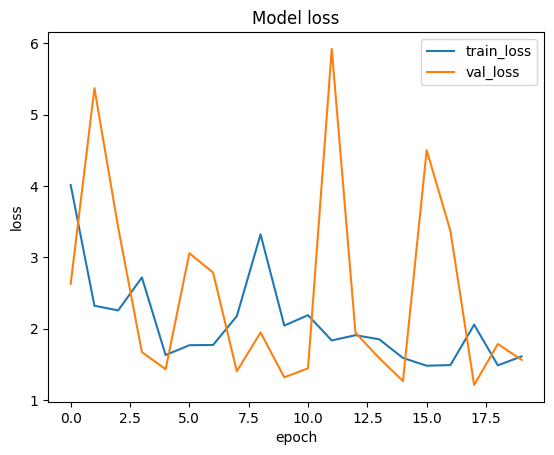

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

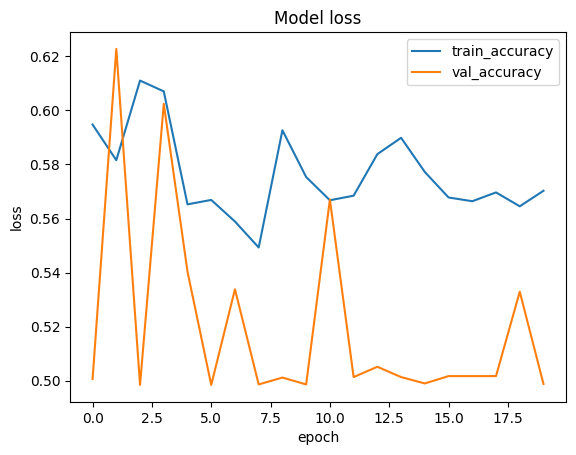

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
lenet_custom_model.evaluate(test_dataset) #model.evaluate

5513/5513 [==============================] - 44s 6ms/step - loss: 0.2127 - tp: 2660.0000 - fp: 244.0000 - tn: 2513.0000 - fn: 96.0000 - accuracy: 0.9383 - precision: 0.9160 - recall: 0.9652 - AUC: 0.9695


[0.21269506216049194,
 2660.0,
 244.0,
 2513.0,
 96.0,
 0.9383276104927063,
 0.915977954864502,
 0.9651669263839722,
 0.9694557189941406]

In [ ]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 10s 10s/step


0.0047665285

Visualizing Confusion Matrix

In [ ]:
#rmd
labels = []
inp = []

for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

print(labels)

[array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([0]), array([1]), array([1]), array([0]), array([0]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([1]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([1]), array([0]), array([0]), array([1]), arr

In [ ]:
labels = np.array([i[0] for i in labels])


IndexError: ignored

In [ ]:
#rmd
predicted = lenet_custom_model.predict(np.array(inp)[:,0,...])
print(predicted[:,0])

NameError: ignored

In [ ]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
#tn fp
#fn tp
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix = {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

ROC Plot

In [ ]:
fp, tp, threshold = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])

plt.show()

NameError: ignored

In [ ]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

1/1 [==============================] - 0s 20ms/step


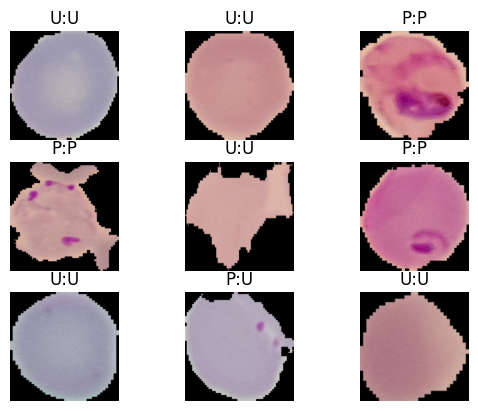

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3,i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0]))+ ":" + str(parasite_or_not(model.predict(image)[0][0])))

  plt.axis('off')

In [ ]:
model.save("SavedModel")

In [ ]:
loaded_model = tf.keras.models.load_model("SavedModel")
loaded_model.summary()

In [ ]:
model.save("SavedModel.hdf5") # not recommended as it doesn't store configuration files

In [ ]:
model.save_weights("weights/model_weights")

In [ ]:
weight_model = model.load_weights("weights/model_weights")

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!cp -r /content/SavedModel/ /content/drive/MyDrive/model_colab

In [ ]:
!cp -r /content/drive/MyDrive/model_colab /content/model_colab